<a href="https://colab.research.google.com/github/buessow/glumagic/blob/master/Glucose_Prediction_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Imports
%load_ext google.colab.data_table

from enum import Enum
import datetime as datetime
import time
import json
import os
import hashlib
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime as datetime
import dateutil.parser
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as lines
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from matplotlib.collections import PatchCollection, LineCollection
from shapely.geometry import Polygon, Point
import matplotlib.table as tab
import math
import numpy as np
import pandas as pd
import pytz
import pprint
import statistics
import sys
import unittest
import subprocess
from datetime import datetime
# from datetime import time
from datetime import timedelta
from datetime import timezone
from google.colab import data_table
from google.colab import drive
from google.colab import output as co_out
from scipy.signal import savgol_filter
from IPython import display as idisplay
import contextlib
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# from google.colab import userdata
from IPython.display import Javascript

#mpl.style.use('dark_background')
data_table._DEFAULT_FORMATTERS[float] = lambda x: f'{x:.2f}'
data_table._DEFAULT_FORMATTERS[np.float32] = lambda x: f'{x:.2f}'
data_table._DEFAULT_ROWS_PER_PAGE = 20

local_colab = 'COLAB_RELEASE_TAG' not in os.environ.keys()
CACHE_DIR = os.path.join(os.environ['HOME'], 'Google Drive', 'My Drive', 'Glucose Prediction Work')
if not os.path.exists(CACHE_DIR):
  local_colab = False
  CACHE_DIR = '/content/drive/My Drive/Glucose Prediction Work'

print(CACHE_DIR)

/Users/robertbuessow/Google Drive/My Drive/Glucose Prediction Work


In [2]:
#@title Import Library from Github
![ -d gmagic ] || git clone https://github.com/buessow/gmagic.git
!cd gmagic; git pull origin
from gmagic.lib import LogNormAction as lna
from gmagic.lib import ExponentialModel as em
from gmagic.lib.DateTimeInsulin import DateTimeInsulin, TimeInsulin
from gmagic.lib.Profile import Profile
from gmagic.lib.ProfileSwitch import ProfileSwitch
from gmagic.lib.TempBasal import TempBasal

Already up to date.


In [3]:
![[ $local_colab == False ]] && apt-get install openjdk-17-jre-headless -qq > /dev/null
if not local_colab: os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
![[ $local_colab == False ]] && update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!java -version

java version "17.0.7" 2023-04-18 LTS
Java(TM) SE Runtime Environment (build 17.0.7+8-LTS-224)
Java HotSpot(TM) 64-Bit Server VM (build 17.0.7+8-LTS-224, mixed mode, sharing)


In [4]:
#@title Model Class
class M(object):
  def __init__(self, name, **kwargs):
    self.name = name
    self.test_data = []
    self.use_conv = False
    for k, v in kwargs.items():
      setattr(self, k, v)
    self.prev_error = {}
m = M('default')

In [5]:
#@title Model Data

M.START = '2020-01-01'
M.END = '2024-03-01'
M.VALIDATION = '2024-03-02'  # Use everything after only for validation
M.VALIDATION_RATIO = 0.2     # Use START..VALIDATION ratio in addition for vali

M.FREQ_MINUTES = 5
M.FREQ = timedelta(minutes=M.FREQ_MINUTES)

M.TRAIN_MINUTES = 180
M.PRED_MINUTES = 60
M.PRED2_MINUTES = 60

@property
def MINUTES(self): return self.TRAIN_MINUTES + self.PRED_MINUTES
M.MINUTES = MINUTES

@property
def PERIOD_T(self): return timedelta(minutes=self.TRAIN_MINUTES)
M.PERIOD_T = PERIOD_T
del PERIOD_T

@property
def PERIOD_P(self): return timedelta(minutes=self.PRED_MINUTES)
M.PERIOD_P = PERIOD_P
del PERIOD_P

@property
def PERIOD(self): return self.PERIOD_T + timedelta(minutes=self.PRED2_MINUTES)
M.PERIOD = PERIOD
del PERIOD

@property
def PERIOD_X_MINUTES(self):
  return list(range(0, self.TRAIN_MINUTES, self.FREQ_MINUTES))
M.PERIOD_X_MINUTES = PERIOD_X_MINUTES

@property
def PERIOD_Y_MINUTES(self):
  return list(range(self.TRAIN_MINUTES, self.MINUTES, self.FREQ_MINUTES))
M.PERIOD_Y_MINUTES = PERIOD_Y_MINUTES

@property
def PERIOD_Y2_MINUTES(self):
  return list(range(self.TRAIN_MINUTES, self.TRAIN_MINUTES + self.PRED2_MINUTES, self.FREQ_MINUTES))
M.PERIOD_Y2_MINUTES = PERIOD_Y2_MINUTES

@property
def PERIOD_INPUT_MINUTES(self):
  return list(range(0, self.TRAIN_MINUTES + self.PRED2_MINUTES, self.FREQ_MINUTES))
M.PERIOD_INPUT_MINUTES = PERIOD_INPUT_MINUTES
del PERIOD_INPUT_MINUTES

@property
def PERIOD_MINUTES(self): return self.PERIOD_X_MINUTES + self.PERIOD_Y_MINUTES
M.PERIOD_MINUTES = PERIOD_MINUTES

M.HR_HIGH_THRESHOLD = 120
M.HR_LONG_MINUTES = [24 * 60, 48 * 60]
M.HR_LONG_COLS = ['hr_long', 'hr_lon2']

@property
def start_ts(self):
  return pd.to_datetime(self.START).tz_localize('UTC')
M.start_ts = start_ts
del start_ts

@property
def validation_start(self):
  return pd.to_datetime(self.VALIDATION).tz_localize('UTC')
M.validation_start = validation_start
del validation_start

history = pd.DataFrame()
history_file = os.path.join(CACHE_DIR, 'run_history.csv')
if os.path.exists(history_file):
  history = pd.read_csv(history_file)

M.shuffle_all = True
m.validation_start

Timestamp('2024-03-02 00:00:00+0000', tz='UTC')

In [6]:
#@title Exponential Model
class ExponentialModel:
  name = 'Exponential'
  def __init__(self, peak, total):
    self.peak = peak
    self.total = total

    self.tp = peak / timedelta(minutes=1)
    self.td = total / timedelta(minutes=1)

    self.tau = self.tp * (1 - self.tp / self.td) / (1 - 2 * self.tp / self.td)
    self.a = 2 * self.tau / self.td
    self.S = 1 / (1 - self.a + (1 + self.a) * math.exp(-self.td / self.tau))

  def insulin_action(self, t):
      """
      Calculates the insulin action at a given time (in minutes).

      Args:
          t (float): Time (in minutes).

      Returns:
          float: The insulin action value.
      """
      return (self.S / (self.tau * self.tau)) * t * (1 - t / self.td) * math.exp(-t / self.tau)

  @property
  def args(self):
    return dict(name=self.name, peak=self.tp, total=self.td)

  def insulin_on_board(self, duration):
      """
      Calculates the amount of insulin remaining active (on board) at a given
      duration after injection.

      Args:
          t (TimeDelta):

      Returns:
          float: The amount of insulin on board.
      """
      if duration < timedelta():
          return 1.0
      elif duration > self.total:
          return 0.0
      else:
          t = duration / timedelta(minutes=1)
          return 1 - self.S * (1 - self.a) * (
              ((t * t) / (self.tau * self.td * (1 - self.a)) - t / self.tau - 1)
              * math.exp(-t / self.tau)
              + 1
          )

  def insulin_used(self, injection, start, upto):
    r = self.insulin_on_board(start - injection) - self.insulin_on_board(upto - injection)
    return r

  def values_at(self, dates, values, start, times):
    """
    Calculates the cumulative value within a time window for each timestamp.

    Args:
        values: List of data points containing timestamp and value.
        start: Starting timestamp for the window.
        times: Iterable of timestamps for which to calculate the value.

    Returns:
        List of doubles representing the cumulative value at each timestamp.
    """
    results = []

    last = start
    win_start = 0
    for t in times:
      # Move the first element in the window
      while win_start < len(values) and t - self.total > dates[win_start]:
        win_start += 1

      total = 0.0
      i = win_start
      # if i % 100 == 0: print('i=%d'% i)
      while i < len(values):
        timestamp, value = dates[i], values[i]
        if timestamp > t: break
        # Calculate insulin used within the window
        insulin_ratio = self.insulin_used(timestamp, last, t)
        total += value * insulin_ratio
        i += 1

      last = t
      results.append(total)
    return results

  def plot(self, time, color='red', label='', ax=None):
    """Plots the action curve over given amount of time.
    Args:
        time: timedelta amount of time
        color: string color of the graph
        label: string label of the graph
        ax: axis to use for plotting."""
    start = datetime(2020, 1, 1)
    end = start + time
    dates = pd.date_range(start, end, freq='min')
    values = self.values_at([start], [1], start, dates)
    df = pd.DataFrame({'date': dates, 'values': values})
    ax = df.plot(ax=ax, x='date', y='values',
                 figsize=(5, 2) if ax is None else None,
                 color=color, label=label)
    ax.set_xticks(pd.date_range(start, end, freq='10min'), minor=True)
    ax.grid(which='both', axis='both', ls=':')


In [7]:
#@title Exponential Model Test
class FiaspInsulinModelTest(unittest.TestCase):
    """
    Test cases for the Fiasp insulin model's insulinOnBoard function.
    """

    def setUp(self):
        self.fiasp = ExponentialModel(peak=timedelta(minutes=55), total=timedelta(hours=6))

    def test_insulin_on_board(self):
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=-1)), 1.0)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta()), 1.0)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=45)), 0.788, delta=1e-3)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=55)), 0.717, delta=1e-3)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=120)), 0.314, delta=1e-3)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=360)), 0.0, delta=1e-3)
        self.assertAlmostEqual(self.fiasp.insulin_on_board(timedelta(minutes=420)), 0.0, delta=1e-3)

    def test_values_at(self):
        """
        Test the valuesAt function for calculating cumulative insulin values.
        """

        t = datetime.fromisoformat("2013-12-13T20:00:00Z").astimezone(timezone.utc)

        # Create a list of timestamps with offsets
        timestamps = [t + timedelta(minutes=m) for m in [5, 30, 55, 120, 180, 230, 360]]

        results = self.fiasp.values_at([t], [5], t, timestamps)
        expected_values = [0.021, 0.537, 0.860, 2.011, 0.999, 0.372, 0.202]
        np.testing.assert_almost_equal(results, expected_values, 2)

        # Verify total insulin delivered matches initial dose
        self.assertAlmostEqual(sum(results), 5.0, delta=1e-2)

        double_results = self.fiasp.values_at([t], [10], t, timestamps)
        double_expected = [value * 2 for value in expected_values]
        np.testing.assert_almost_equal(double_results, double_expected, 2)
        self.assertAlmostEqual(sum(double_results), 10.0, delta=1e-2)

unittest.main(argv=[''], verbosity=2, exit=False)


test_insulin_on_board (__main__.FiaspInsulinModelTest.test_insulin_on_board) ... ok
test_values_at (__main__.FiaspInsulinModelTest.test_values_at)
Test the valuesAt function for calculating cumulative insulin values. ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


mode 0.750000


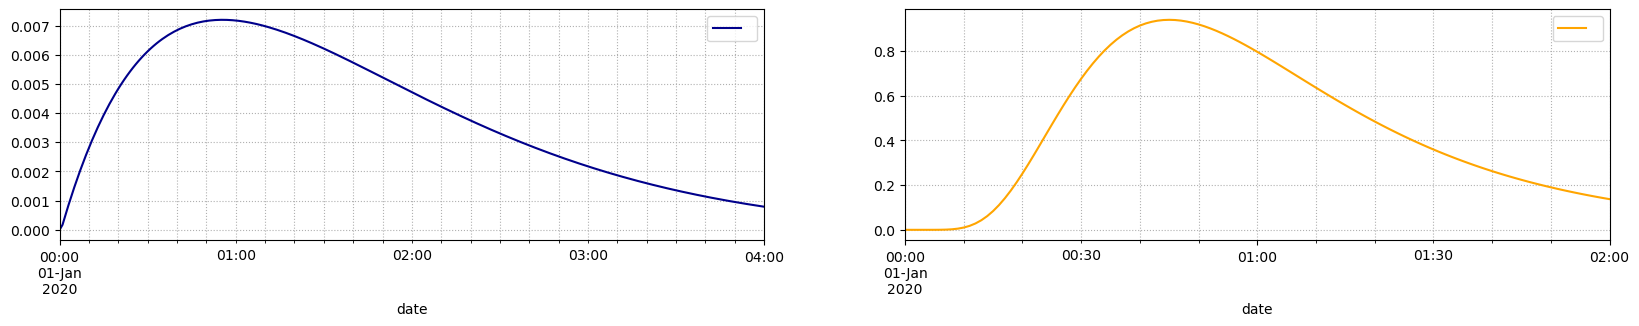

In [8]:
#@title Insulin and Carbohydrate Action
insulin_color = 'darkblue'
carb_color = 'orange'

M.INSULIN_ACTION = em.ExponentialModel(peak=timedelta(minutes=55), total=timedelta(minutes=360))
M.CARB_ACTION = lna.LogNormAction(mode=timedelta(minutes=45), sigma=0.50)

_, axs = plt.subplots(nrows=1, ncols=2, subplot_kw={}, figsize=(20,3))
M.INSULIN_ACTION.plot(timedelta(hours=4), color=insulin_color, ax=axs[0])
M.CARB_ACTION.plot(timedelta(hours=2), color=carb_color, ax=axs[1])

# print('mean %f' % M.INSULIN_ACTION.mean)

# Data Loading

In [9]:
#@title Output Meta Json

@property
def meta0(self):
  return {
      'trainingPeriodMinutes': self.TRAIN_MINUTES,
      'predictionPeriodMinutes': self.PRED_MINUTES,
      'carbAction': self.CARB_ACTION.args,
      'insulinAction': self.INSULIN_ACTION.args,
      'hrHighThreshold': self.HR_HIGH_THRESHOLD,
      'hrLongDurationMinutes': self.HR_LONG_MINUTES,
      'freqMinutes': self.FREQ_MINUTES }
M.meta0 = meta0
del meta0

@property
def meta(self):
  return {
      **self.meta0,
      'tensorflow_version': tf.__version__,
      'testData': self.test_data,
      'zoneId': 'CET',
      'xValues': self.get_x_values() if hasattr(self, 'get_x_values') else [],
      'yValues': self.get_y_values() if hasattr(self, 'get_y_values') else []
  }
M.meta = meta
del meta

def write_meta_json(self, file_name, meta):
  with open(file_name, 'w') as f:
    json.dump(meta, f, indent=2)
  return meta
M.write_meta_json = write_meta_json
del write_meta_json


In [10]:
#@title Load Data

def load_data(self):
  meta_fname = '%s_load_meta.json' % self.name
  meta =  self.write_meta_json(meta_fname, self.meta0)
  meta['testData'] = None
  hash = hashlib.sha1(str(meta).encode()).hexdigest()
  fname = 'input_%s_%s_%s.csv' % (self.START, self.END, hash)
  if not os.path.exists(fname):
    print('loading "%s"' % fname)
    with open(CACHE_DIR + '/mongo.json') as f:
      mongo_config = json.load(f)
    p = subprocess.run(args=[
        'java',
        '-jar', os.path.join(CACHE_DIR, 'glumagic-1.0.jar'),
        # 'api',
        # '--apiKey', mongo_config['apiKey'],
        # '--serverUrl', mongo_config['serverUrl'],
        'db',
        '--userName', mongo_config['databaseUser'],
        '--password', mongo_config['databasePassword'],
        '--server', 'mongodb+srv://cluster0.10utl.gcp.mongodb.net',
        '--outFile', fname,
        '--configFile', meta_fname,
        '--from', self.START,
        '--upto', self.END,
        '--database', mongo_config['database']],
        capture_output=True, encoding='UTF-8',
        env={'JAVA_HOME': '/usr/lib/jvm/java-17-openjdk-amd64'})
    print('loading result %d %s %s' % (p.returncode, p.stderr, p.stdout))
    if not os.path.exists(fname) or os.stat(fname).st_size == 0:
      raise Exception("%s has no data" % fname)

  self.glucose = pd.read_csv(fname)
  self.glucose.date = pd.to_datetime(self.glucose.date)
  self.glucose.set_index('date', inplace=True)
  # self.glucose['year'] = self.glucose.index.map(lambda ts: ts.year)
  # self.glucose['month'] = (self.glucose.year - 2000) * 12 + self.glucose.index.map(lambda ts: ts.month)
  self.glucose.rename({
    'glucoseSlope1': 'gl_slope',
    'glucoseSlope2': 'gl_slop2',
    'hrLong1': 'hr_long',
    'hrLong2': 'hr_lon2',
    'heartRate': 'hr',
    'carbAction': 'ca',
    'insulinAction': 'ia'}, axis=1, errors='raise', inplace=True)
  self.glucose.glucose.where(self.glucose.glucose > 20.0, inplace=True)
  self.glucose.glucose.ffill(limit=6, inplace=True)
  self.glucose.hr.ffill(limit=3, inplace=True)
  self.glucose.hr.fillna(value=60.0, inplace=True)
  self.glucose.dropna(inplace=True, subset=['glucose'])
  self.glucose['ins'] = self.glucose.basal + self.glucose.bolus

  print('load data from %s, shape=%s' % (fname, str(self.glucose.shape)))

M.load_data = load_data
m.load_data()
print('glucose data: %s' % str(m.glucose.shape))
m.glucose.index
m.glucose[['glucose', 'hr', 'carbs', 'ca', 'ins', 'ia']][-1000:] #[410000:][:10000]

load data from input_2020-01-01_2024-03-01_28493f9fd67c5de71d7b270bae96f0701f7bc507.csv, shape=(427825, 13)
glucose data: (427825, 13)


,glucose,hr,carbs,ca,ins,ia
date,,,,,,
2024-02-26 12:40:00+00:00,112.157191,59.00000,0.0,0.600838,1.249884,0.072518
2024-02-26 12:45:00+00:00,120.438127,60.00000,0.0,0.511535,0.604167,0.081656
2024-02-26 12:50:00+00:00,123.789298,61.00000,0.0,0.435902,0.007950,0.096954
2024-02-26 12:55:00+00:00,125.859532,60.03537,0.0,0.371819,0.027089,0.112105
2024-02-26 13:00:00+00:00,123.220000,60.00000,0.0,0.317490,0.000000,0.124101
...,...,...,...,...,...,...
2024-02-29 23:35:00+00:00,99.518395,46.00000,0.0,33.953938,0.737816,0.055893
2024-02-29 23:40:00+00:00,98.120401,46.00000,0.0,31.982620,0.011000,0.059305
2024-02-29 23:45:00+00:00,97.060201,46.00000,0.0,29.354348,0.000000,0.065382


In [11]:
m.glucose.ins.sum(), m.glucose.ia.sum()

(75666.35857881387, 75508.31932086298)

In [12]:
m.glucose.index.array

<DatetimeArray>
['2020-01-01 03:45:00+00:00', '2020-01-01 03:50:00+00:00',
 '2020-01-01 03:55:00+00:00', '2020-01-01 04:00:00+00:00',
 '2020-01-01 04:05:00+00:00', '2020-01-01 04:10:00+00:00',
 '2020-01-01 04:15:00+00:00', '2020-01-01 04:20:00+00:00',
 '2020-01-01 04:25:00+00:00', '2020-01-01 04:30:00+00:00',
 ...
 '2024-02-29 23:10:00+00:00', '2024-02-29 23:15:00+00:00',
 '2024-02-29 23:20:00+00:00', '2024-02-29 23:25:00+00:00',
 '2024-02-29 23:30:00+00:00', '2024-02-29 23:35:00+00:00',
 '2024-02-29 23:40:00+00:00', '2024-02-29 23:45:00+00:00',
 '2024-02-29 23:50:00+00:00', '2024-02-29 23:55:00+00:00']
Length: 427825, dtype: datetime64[ns, UTC]

In [13]:
def compute_action(self, start=None, df=None):
  df = self.glucose if df is None else df
  s = pd.to_datetime(self.START + 'T00:00:00Z') if start is None else start
  carbs = self.glucose.carbs[self.glucose.carbs > 0]
  # m.glucose['ca'] = list(self.CARB_ACTION.values_at(
  #     carbs.index.array, carbs.array, s, self.glucose.index.array))
  ins = df.ins[df.ins > 0]
  df['ia'] = list(self.INSULIN_ACTION.values_at(
      ins.index.array, ins.array, s, df.index.array))
  df.ia = 1000 * df.ia
  return df
M.compute_action = compute_action
del compute_action

# m.compute_action(df=m.glucose.head(1000).copy())
# m.glucose[['glucose', 'hr', 'carbs', 'ca', 'ins', 'ia']][-1000:] #[410000:][:10000]

In [14]:
m.glucose.index

DatetimeIndex(['2020-01-01 03:45:00+00:00', '2020-01-01 03:50:00+00:00',
               '2020-01-01 03:55:00+00:00', '2020-01-01 04:00:00+00:00',
               '2020-01-01 04:05:00+00:00', '2020-01-01 04:10:00+00:00',
               '2020-01-01 04:15:00+00:00', '2020-01-01 04:20:00+00:00',
               '2020-01-01 04:25:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2024-02-29 23:10:00+00:00', '2024-02-29 23:15:00+00:00',
               '2024-02-29 23:20:00+00:00', '2024-02-29 23:25:00+00:00',
               '2024-02-29 23:30:00+00:00', '2024-02-29 23:35:00+00:00',
               '2024-02-29 23:40:00+00:00', '2024-02-29 23:45:00+00:00',
               '2024-02-29 23:50:00+00:00', '2024-02-29 23:55:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=427825, freq=None)

In [15]:
def compute_24(self):
  df = self.glucose
  df['carbs24'] = df.carbs.rolling(window=timedelta(days=1)).sum()
  df['ins24'] = df.ins.rolling(window=timedelta(days=1)).sum()
  df['ci24'] = df.carbs24 / df.ins24
M.compute_24 = compute_24
del compute_24

m.compute_24()
m.glucose.describe()
m.glucose[m.glucose.carbs > 150]

,hour,glucose,gl_slope,gl_slop2,hr,hr_long,hr_lon2,carbs,ca,bolus,basal,ia,ins,carbs24,ins24,ci24
date,,,,,,,,,,,,,,,,
2020-01-06 17:30:00+00:00,17,183.926421,1.321526,-0.367577,60.000000,0.0,0.0,160.0,2.486683e-01,12.8,0.082249,0.386868,12.882249,230.0,99.988554,2.300263
2020-01-28 11:40:00+00:00,11,66.979933,2.807473,0.096581,60.000000,0.0,0.0,160.0,1.790038e-10,8.0,0.069600,0.165492,8.069600,560.0,97.446539,5.746741
2020-01-31 04:05:00+00:00,4,116.023569,0.286714,-0.094257,60.000000,0.0,0.0,160.0,2.475422e-01,12.8,0.048544,0.356015,12.848544,450.0,131.782180,3.414726
2020-02-02 02:10:00+00:00,2,72.434783,1.462207,0.280000,60.000000,0.0,0.0,160.0,3.147101e+01,10.0,0.000000,0.212129,10.000000,1070.0,74.545572,14.353636
2020-04-13 19:05:00+00:00,19,168.238255,-0.611016,0.062023,60.000000,0.0,0.0,160.0,2.324246e-06,0.0,0.000000,0.467845,0.000000,410.0,76.852108,5.334922
2020-04-20 18:40:00+00:00,18,134.793333,4.002204,0.209831,60.000000,0.0,0.0,160.0,2.403153e+01,12.8,0.052667,0.099034,12.852667,350.0,75.685223,4.624417
2020-05-12 18:15:00+00:00,18,130.167763,3.433553,0.008970,65.963333,0.0,0.0,160.0,0.000000e+00,12.8,0.463333,0.091431,13.263333,260.0,71.170771,3.653185
2020-05-15 17:25:00+00:00,17,93.973333,0.390640,0.157323,73.212034,0.0,16.0,160.0,1.028319e-07,8.0,0.000000,0.195459,8.000000,300.0,69.812347,4.297234
2020-05-17 17:35:00+00:00,17,126.890000,0.611445,-0.068346,68.400000,13.0,33.0,160.0,1.430485e+01,10.0,0.030816,0.293780,10.030816,900.0,80.608873,11.165024


In [16]:
#@title Slope Series
def slope_series(y_series, x_series, x_per=1):
  # x_diff = x_series.shift(-1) - x_series
  # y_diff = y_series.shift(-1) - y_series
  x_diff = x_series - x_series.shift(1)
  y_diff = y_series - y_series.shift(1)
  return y_diff / (x_diff / x_per)

smooth glucose
smoothing mean abs error 0.81%


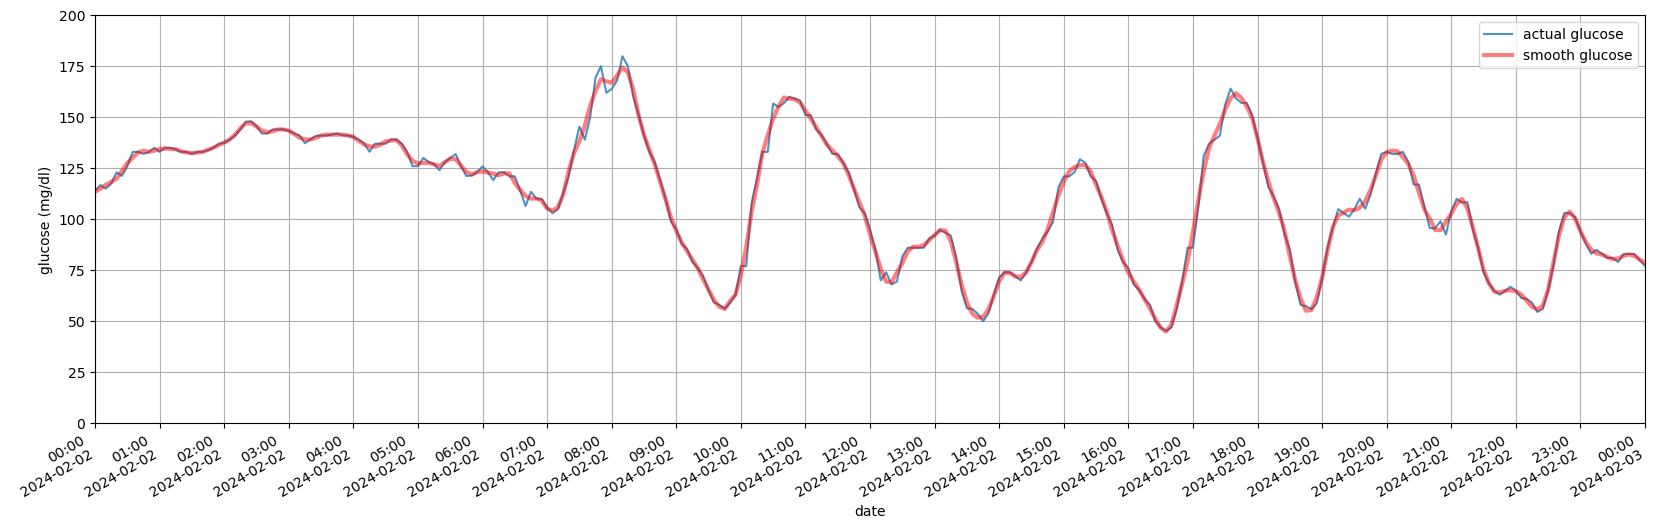

In [17]:
#@title Smooth Glucose

class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    callback_id = 'button-10sasdf'
    co_out.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

def do_something():
  print('here')

def compute_slopes(df):
  df.gl_slope = slope_series(df.glucose, df.index.to_series(), timedelta(minutes=1))
  df.gl_slop2 = slope_series(df.gl_slope, df.index.to_series(), timedelta(minutes=1))

compute_slopes(m.glucose)

def smooth_glucose(df):
  df = df.copy()
  df.glucose = savgol_filter(df.glucose, window_length=7, polyorder=2)
  compute_slopes(df)
  return df


M.smooth_glucose = False

def ensure_smooth(self, smooth):
  if self.smooth_glucose == smooth: return
  if smooth:
    print('smooth glucose')
    self.raw_glucose = self.glucose
    self.glucose = smooth_glucose(self.glucose)
  else:
    self.glucose = self.raw_glucose
  self.smooth_glucose = smooth
  if (hasattr(self, 'pivot_input')):
    print('pivot input')
    self.pivot_input()
    self.compute_sample_weight()
M.ensure_smooth = ensure_smooth
del ensure_smooth

# InvokeButton('click me', do_something)

m.ensure_smooth(True)

df = smooth_glucose(m.raw_glucose)
mape = mean_absolute_percentage_error(m.raw_glucose.glucose, df.glucose)
print('smoothing mean abs error %.2f%%' % (100*mape))

_, ax = plt.subplots(figsize=(20, 6))
s = pd.to_datetime('2024-02-02')
xlim = (s, s + timedelta(days=1))
ylim = (0, 200)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%Y-%m-%d'))

m.raw_glucose.glucose.plot(ax=ax, xlim=xlim, ylim=ylim, alpha=0.8, label='actual glucose')
df.glucose.plot(ax=ax, xlim=xlim, ylim=ylim, color='red', alpha=0.5, linewidth=3, label='smooth glucose')
ax.grid(True)
ax.yaxis.set_label_text('glucose (mg/dl)')
ax.legend()


<IPython.core.display.Javascript object>

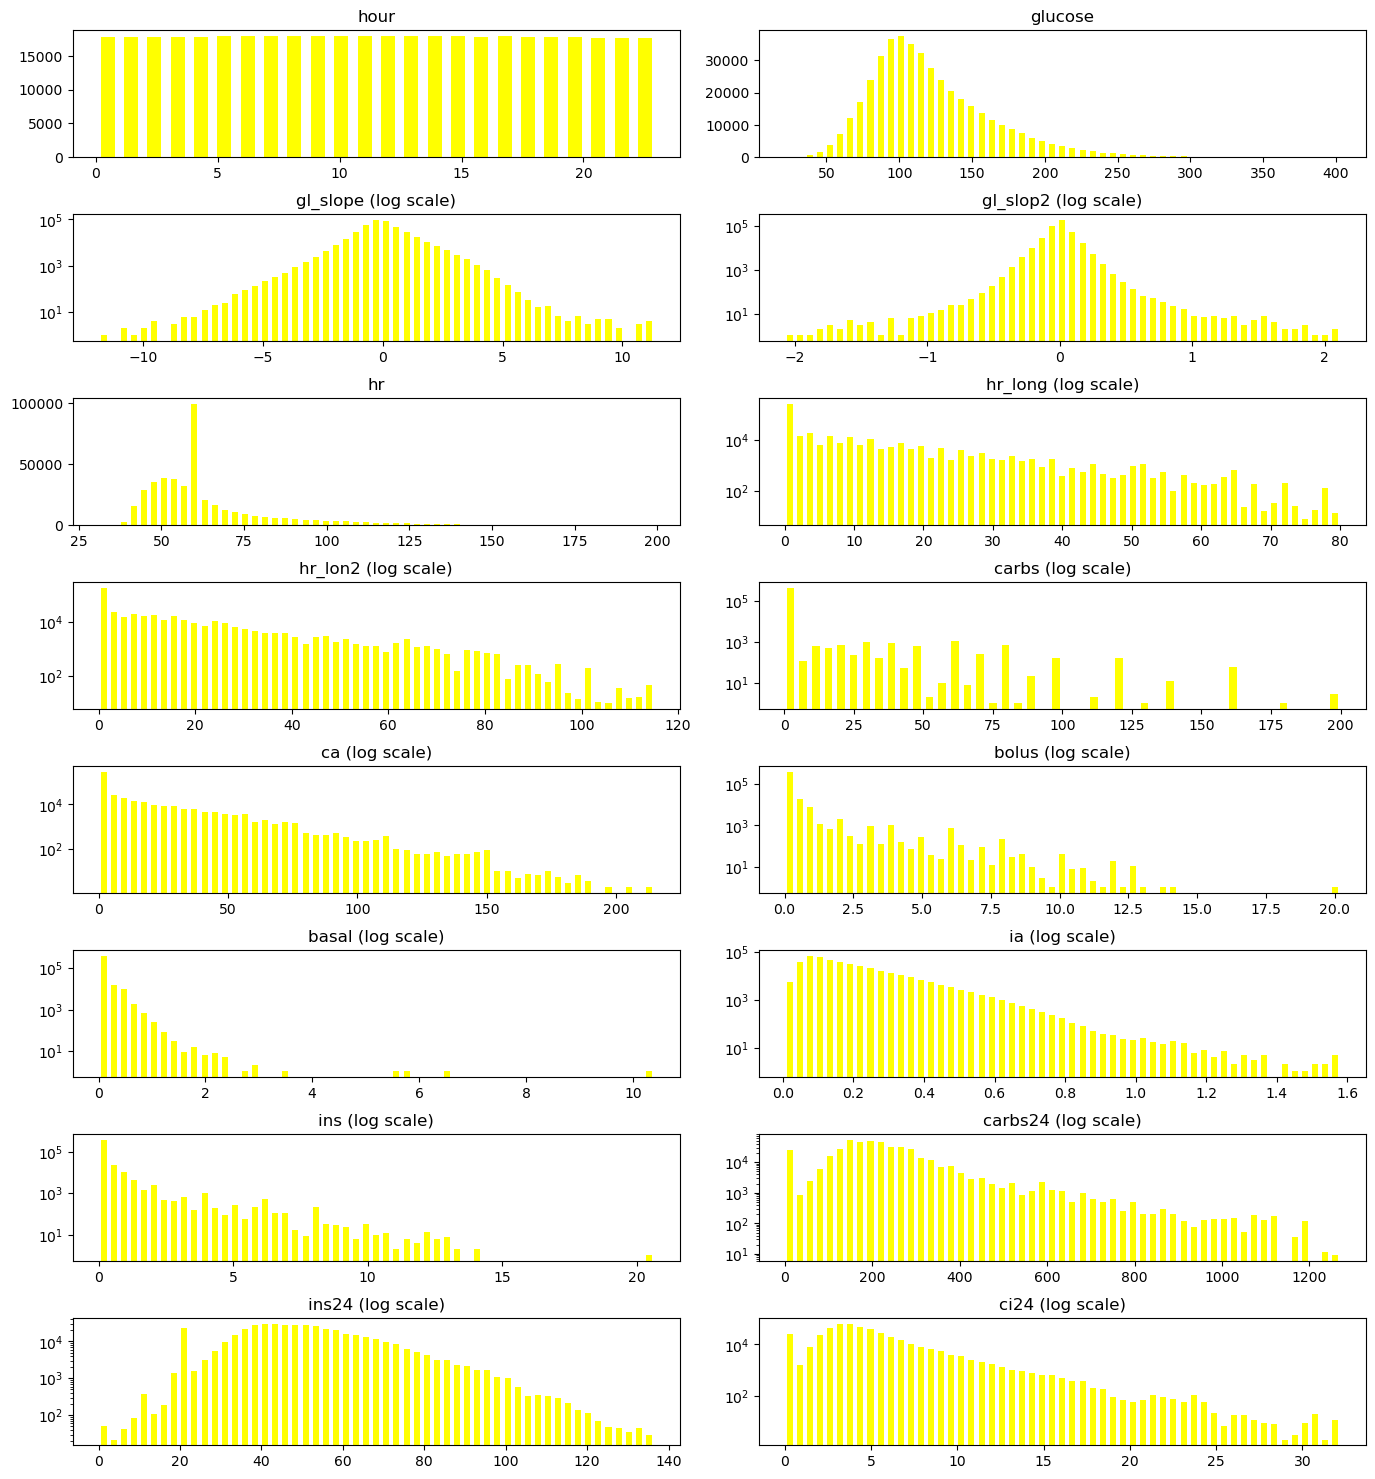

In [18]:
#@title Data Statistics
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

def statistics(self):
  self.glucose.describe()
  no_log_features = ['hour', 'glucose', 'glucose1', 'gl_pred', 'hr']

  fig, axs = plt.subplots(nrows=(len(self.glucose.columns)+1) // 2, ncols=2, figsize=(14, 15))
  fig.tight_layout(pad=2.0)
  axs = axs.flatten()
  for i, c in enumerate(self.glucose.columns):
    col = self.glucose[c]
    log = c not in no_log_features
    axs[i].hist(
        x=col.values, log=log, bins=min(col.nunique(), 55),
        label=c, rwidth=0.6, color='yellow')
    axs[i].set_title(c + (' (log scale)' if log else ''))

M.statistics=statistics
m.statistics()

In [19]:
# #@title Experimental Insulin Action

# import tensorflow_probability as tfp

# df = m.glucose.copy()
# df['minute15'] = df.index.map(lambda ts: ts.replace(minute=15 * (ts.minute // 15)))


# df - df.groupby(by=['minute15']).mean()



# td = timedelta(minutes=120)
# tdc = timedelta(minutes=60)

# window_th = 0.3

# bolus = df.bolus > 3

# # indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=td)
# window_bolus = (df
#       .bolus.map(lambda b: b if b > window_th else 0.0)
#       .rolling(window=tdc, center=False)
#       #.apply(lambda b: b[b > window_th]
#       .sum())
# window_carbs = (df
#       .carbs
#       .rolling(window=2*td, center=True)
#       #.apply(lambda b: b[b > window_th]
#       .sum())

# df['clean_bolus'] = (df.bolus == window_bolus) & bolus & (window_carbs < 0.1)

# ts = None
# gl = None
# points = []
# means = []
# modes = []
# for row in df.itertuples():
#   if row.clean_bolus:
#     ts = row.Index
#     gl = row.glucose
#     #print('Start %s bolus=%f' % (str(ts), row.bolus))
#   elif ts is not None and row.Index - ts < td:
#     minutes = int((row.Index-ts)/timedelta(minutes=1))
#     # print('Cont %s bolus=%f slope=%f' % (str(minutes), row.bolus, row.glucose))
#     points.append(row.glucose - gl)
#   elif len(points) > 0 and len(points) > 10:
#     ln = tfp.distributions.LogNormal.experimental_fit(points)
#     mean = ln.mean().numpy()
#     if not np.isnan(mean):
#       means.append(mean)
#       modes.append(ln.mode().numpy() / 12)
#       print('Mean: %f mode: %f' % (mean, ln.mode().numpy() / 4))
#     points = []
#   else:
#     points = []

# pd.Series(modes).median()

# # print('ln %f %f' % (ln.loc, ln.scale))

In [20]:
# ln = tfp.distributions.LogNormal.experimental_fit([1., 2., 1.])

# print(ln)


# print(ln.mean().numpy())
# print(ln.variance().numpy())



# data = ln.sample(10)
# ln1 = tfp.distributions.LogNormal(1, 1)
# data=ln1.sample(100)

# x = np.linspace(0, 10, 100, dtype=np.float64)
# plt.scatter(x=x, y=ln.prob(x), color='red', alpha=0.4)

# # ln1.log_prob([1,2])
# ln1.prob(x)

In [21]:
#@title Adjust for Level Dependent Insulin Sensitivity

def adjust_insulin_sensitivity(self, glucose=None, threshold=60):
  if glucose is None: glucose = self.glucose
  glucose.ia = glucose.ia * glucose.glucose.apply(lambda g: 1 if g > threshold else 1.5)
M.adjust_insulin_sensitivity = adjust_insulin_sensitivity
del adjust_insulin_sensitivity

# m.adjust_insulin_sensitivity()

# Setup and Train Model

In [22]:
def value_col_name(n, m):
  if n == 'glucose': n = 'gl'
  elif n == 'gl_slope': n = 'gls'
  elif n == 'gl_slop2': n = 'gls2'
  elif n == 'heart_rate': n = 'hr'
  return '%s_%03d' % (n, m)
def gl_col_name(m): return value_col_name('glucose', m)
def gl_slope_col_name(m): return value_col_name('gl_slope', m)
def gl_slop2_col_name(m): return value_col_name('gl_slop2', m)
def ia_col_name(m): return value_col_name('ia', m)
def ca_col_name(m): return value_col_name('ca', m)
def hr_col_name(m): return value_col_name('hr', m)

In [23]:
#@title Features

M.features = [
    'hour',
    # 'month',
    # 'year',
    'glucose',
    'gl_slope',
    'gl_slop2',
    'ins',
    'ia',
    'carbs',
    'ca',
    'hr',
    'hr_long',
    'hr_lon2',
]

class FeatureMode(Enum):
  SKIP = 0,         # Don't use the feature.
  FIRST = 1,        # Use the first value of the period.
  X_MINUTES = 2,    # Use all values in the X period.
  X1_MINUTES = 6,    # Use all values in the X period but the last.
  Y_MINUTES = 3,    # Use all values in the Y period.
  MINUTES = 4,      # Use all values in the period.
  MINUTES_Y0 = 5,   # Use all values in the X period and fill Y with 0.

  def __repr__(self):
    return self.name

  def __eq__(self, other):
    return other is not None and hasattr(other, 'value') and self.value == other.value


def make_feature_def(self, **kwargs):
  unknown = kwargs.keys() - set(self.features)
  if len(unknown) > 0:
    raise Exception('unknown feature(s) %s' % str(unknown))
  return {**{f: FeatureMode.SKIP for f in self.features}, **kwargs}
M.make_feature_def = make_feature_def
del make_feature_def

x_feature_def = M.make_feature_def(M,
    hour=FeatureMode.FIRST,
    glucose=FeatureMode.X_MINUTES,
    gl_slope=FeatureMode.X_MINUTES,
    gl_slop2=FeatureMode.X_MINUTES,
    ins=FeatureMode.X_MINUTES,
    carbs=FeatureMode.X_MINUTES,
    hr=FeatureMode.X_MINUTES,
    hr_long=FeatureMode.X_MINUTES,
    hr_lon2=FeatureMode.X_MINUTES)
M.x_feature_def = x_feature_def
del x_feature_def

y_feature_def = M.make_feature_def(M, gl_slope=FeatureMode.Y_MINUTES)
M.y_feature_def = y_feature_def
del y_feature_def

@property
def used_x_features(self):
  return [f for f in self.features if self.x_feature_def[f] != FeatureMode.SKIP]
M.used_x_features = used_x_features
del used_x_features


@property
def used_y_features(self):
  return [f for f in self.features if self.y_feature_def[f] != FeatureMode.SKIP]
M.used_y_features = used_y_features
del used_y_features

In [24]:
#@title Shuffle
def shuffle(self, df, batch_size=None):
  batch_size = batch_size or (self.MINUTES // 60)
  df = df[:batch_size * (df.shape[0] // batch_size)]
  index_list = np.array(df.index)
  np.random.shuffle(np.reshape(index_list, (-1, batch_size)))
  return df.loc[index_list, :]
M.shuffle = shuffle
del shuffle

In [ ]:
#@title Pivot Input


def datetime_to_period(self, dt, start_ts):
  t = dt - start_ts
  p = self.PERIOD * (t // self.PERIOD)
  return p + start_ts
M.datetime_to_period = datetime_to_period

def pivot_for_model(self, gl=None, start_ts=None):
  if not hasattr(self, 'glucose'): self.load_data()
  df = (self.glucose if gl is None else gl).copy()
  start_ts = self.start_ts if start_ts is None else start_ts
  if not set(self.features) <= set(df.columns):
    raise Exception('missing column(s) %s' % str(set(self.features) - set(df.columns)))

  # Add a minute column for the minute within a period, e.g. if the period is 4
  # hours (3h x, 1h y) and value frequency is 5 minutes, the minute column has
  # values 0, 5, 10, ... 235.
  df['minute'] = df.index.map(
      lambda dt: self.FREQ_MINUTES * ((dt - self.datetime_to_period(dt, start_ts)) // self.FREQ))
  df.index = df.index.map(lambda ts: self.datetime_to_period(ts, start_ts))
  df.reset_index(inplace=True)

  # Aggregate values, usually we get a single value. Compute the mean if there
  # are multiple.
  def agg(x):
    return float(x if pd.api.types.is_scalar(x) else sum(x) / len(x))
  df = pd.pivot_table(
      df, index=['date'], columns='minute',
      values=self.features,
      aggfunc=dict(hour='min', **{v: agg for v in self.features if v != 'hour'}))

  # Lift the sub-columns up, e.g. rename df['glucose'][5] to df['glucose_005']
  r = pd.concat(
      {value_col_name(v, m): df[v][m] for v in self.features for m in self.PERIOD_INPUT_MINUTES},
      axis=1).dropna()

  if gl is None: self.input = r
  return r
M.pivot_for_model = pivot_for_model
del pivot_for_model

def order_cols(df, cols, fill):
  o = df.copy()
  if fill is None:
    cols = [c for c in cols if c in df.columns]
  else:
    for c in cols:
      if c not in df.columns:
        o[c] = fill
  return o[cols].copy()

def pivot_input(self):
  def pivot(df):
    input = pd.concat(
        [ self.pivot_for_model(
            df[h * 12:],
            start_ts=self.start_ts + timedelta(hours=h))
          for h in range(0, self.MINUTES // 60)])
    return input.sort_index()
  self.input = pivot(self.glucose)
  if self.shuffle_all:
    self.input = self.shuffle(self.input, batch_size=24)
M.pivot_input = pivot_input
del pivot_input

m.pivot_input()
print('input shape %s' % str(m.input.shape))
# data_table.DataTable(m.input.head(2000), max_columns=100)
m.input.describe().T


In [ ]:
#@title Split Training, Prediction, and Validation Data

M.predict_accumulated_slope = False
M.batch_size = 1  # redefined later
M.validation_rows = 6500

def _mode_to_minutes(self, mode):
  if mode == FeatureMode.FIRST: return ([0],[])
  if mode == FeatureMode.X_MINUTES: return (self.PERIOD_X_MINUTES, [])
  if mode == FeatureMode.X1_MINUTES: return (self.PERIOD_X_MINUTES[:-1], [])
  if mode == FeatureMode.Y_MINUTES: return (self.PERIOD_Y_MINUTES, [])
  if mode == FeatureMode.MINUTES: return (self.PERIOD_MINUTES, [])
  if mode == FeatureMode.MINUTES_Y0: return (self.PERIOD_X_MINUTES, self.PERIOD_Y_MINUTES)
  if mode == FeatureMode.SKIP: return ([], [])
  raise Exception('unknown mode "%s"' % (mode))
M._mode_to_minutes = _mode_to_minutes
del _mode_to_minutes

def _get_values(self, feature_def):
  names = []
  for feature in self.features:
    for minute in self.PERIOD_MINUTES:
      value_minutes, zero_minutes = self._mode_to_minutes(feature_def[feature])
      if minute in value_minutes: names.append(value_col_name(feature, minute))
      if minute in zero_minutes: names.append('0')
  return names

def get_x_values(self): return _get_values(self, self.x_feature_def)
M.get_x_values = get_x_values
del get_x_values
def get_y_values(self): return _get_values(self, self.y_feature_def)
M.get_y_values = get_y_values
del get_y_values

def _get_series(self, df, feature, mode, minute):
  value_minutes, zero_minutes = self._mode_to_minutes(mode)
  col = value_col_name(feature, minute)
  if minute in value_minutes: return df[col]
  if minute in zero_minutes: return pd.Series(name=col, index=df.index, data=0.0)
  return None
M._get_series = _get_series
del _get_series

def _series_feature_minute(self, df, feature_def):
  cols = []
  for feature in self.features:
    for minute in self.PERIOD_MINUTES:
      cols.append(self._get_series(df, feature, feature_def[feature], minute))
  return pd.concat(filter(lambda s: s is not None, cols), axis=1)

def _series_minute_feature(self, df, feature_def):
  cols = []
  for minute in self.PERIOD_MINUTES:
    for feature in self.features:
      cols.append(self._get_series(df, feature, feature_def[feature], m))
  return pd.concat(filter(None, cols))

M._get_all_series = _series_feature_minute
del _series_feature_minute
del _series_minute_feature

def batch_multi(self, n):
  return self.batch_size * (int(n) // self.batch_size)
M.batch_multi = batch_multi
del batch_multi

def take_batches(self, df):
  return df[:self.batch_multi(df.shape[0])]
M.take_batches = take_batches
del take_batches

def _validation0(self, df):
  return df[df.index >= self.validation_start]
M._validation0 = _validation0
del _validation0

def _add_validation_rows(self, df):
  total_rows = df.shape[0]
  min_val_rows = self.batch_multi(total_rows * self.VALIDATION_RATIO)
  return max(0, min_val_rows - self._validation0(df).shape[0])
M._add_validation_rows = _add_validation_rows
del _add_validation_rows

@property
def train(self, df=None):
  if df is None: df = self.input
  df = self.take_batches(
      df[df.index < self.validation_start][self._add_validation_rows(df):])
  # df.gls_175 = df.gls_170
  df.gls2_170 = df.gls2_165
  return df
M.train = train
del train

@property
def validation(self, df=None):
  if df is None: df = self.input
  # return self.take_batches(df[:self.validation_rows])
  df = self.take_batches(pd.concat([
      df[df.index < self.validation_start][:self._add_validation_rows(df)],
      self._validation0(df)]))
  df.gls2_170 = df.gls2_165
  return df
M.validation = validation
del validation

def x_data(self, df):
  return self._get_all_series(df, self.x_feature_def)
M.x_data = x_data
del x_data

def y_data(self, df):
  return self._get_all_series(df, self.y_feature_def)
M.y_data = y_data
del y_data

def print_xy_shape(name, df):
  print('%s  X = %5d x %3d  Y = %5d x %2d' % (name, *m.x_data(df).shape, *m.y_data(df).shape))

print('additional validation: %d' % m._add_validation_rows(m.input))
print_xy_shape('All  ', m.input)
print_xy_shape('Train', m.train)
print_xy_shape('Valid', m.validation)
print_xy_shape('Vali0', m._validation0(m.input))

# pd.concat([m.train[['gls_230', 'gls_235']], m.input[['gls_235']]], axis=1)

In [ ]:
#@title Sample Weights

M.low_glucose = 70
M.high_glucose = 150
M.turn_slope_th = 1
M.low_weight = 3
M.high_weight = 1
M.turn_weight = 2
M.critical_slope = 1.3
M.critical_slope_weight = 1
M.active_weight = 1 #3

@property
def last_glucose_col(self):
  return gl_col_name(self.PERIOD_X_MINUTES[-1])
M.last_glucose_col = last_glucose_col

@property
def y_glucose_cols(self):
  return list(map(gl_col_name, self.PERIOD_Y_MINUTES))
M.y_glucose_cols = y_glucose_cols

@property
def gl_slope_cols(self):
  return list(map(gl_slope_col_name, self.PERIOD_Y_MINUTES))
M.gl_slope_cols = gl_slope_cols

@property
def hr_cols(self):
  return list(map(hr_col_name, self.PERIOD_MINUTES))
M.hr_cols = hr_cols
del hr_cols

def active(self, df):
  return df[self.hr_cols].mean() > 90
M.active = active
del active

def compute_sample_weight(self):
  def m(y):
    predict_low = (
        y[self.y_glucose_cols].min() < self.low_glucose and
        y[self.last_glucose_col] > self.low_glucose)
    predict_dec = (
        y[self.last_glucose_col] >  self.critical_slope * y[self.y_glucose_cols].min())
    predict_inc = (
        y[self.last_glucose_col] <  y[self.y_glucose_cols].max() / self.critical_slope)
    predict_turn = (
        y[self.gl_slope_cols].min() < -self.turn_slope_th and
        y[self.gl_slope_cols].max() > self.turn_slope_th)
    active = self.active(y)
    weight = self.low_weight if predict_low else 1
    weight *= self.critical_slope_weight if (predict_dec | predict_inc) else 1
    weight *= self.active_weight if active else 1
    weight = weight * (self.turn_weight if predict_turn else 1)
    return weight
  self.input['sample_weight'] = self.input.apply(m, axis=1)
M.compute_sample_weight = compute_sample_weight
m.compute_sample_weight()

m.input.sample_weight.hist()

In [ ]:
# x=m.x_data(m.take_batches(m.validation))

# m.model.predict(x, verbose=0, batch_size=32)

In [ ]:
#@title Predict Values

def predict_from_slope(self, features, add_glucose=False):
  v = self.take_batches(features)
  x = self.x_data(v)
  pred_arrays = self.model.predict(x, verbose=0, batch_size=self.batch_size).transpose()
  prediction = pd.DataFrame(index=v.index)
  prev = 0.0
  for i, m in enumerate(self.PERIOD_Y_MINUTES):
    prediction[gl_slope_col_name(m)] = pred_arrays[i] - prev
    if self.predict_accumulated_slope:
      prev = pred_arrays[i]

  if (add_glucose):
    last_value_m = self.PERIOD_X_MINUTES[-1]
    last_glucose_col = gl_col_name(self.PERIOD_X_MINUTES[-1])
    prediction[last_glucose_col] = v[last_glucose_col]
    s = v[last_glucose_col]
    freq = self.FREQ_MINUTES
    for m in self.PERIOD_Y_MINUTES:
      gls = prediction[gl_slope_col_name(m)]
      prediction[gl_col_name(m)] = \
          (m - last_value_m) * gls + prediction[gl_col_name(last_value_m)]
      prediction[gl_col_name(m)].clip(lower=30, upper=300, inplace=True)
      if not self.predict_accumulated_slope:
        last_value_m = m

  return prediction
M.predict_from_slope = predict_from_slope
del predict_from_slope

def predict_from_glucose(self, features):
  v = self.take_batches(features)
  x = self.x_data(v)
  pred_arrays = self.model.predict(x, verbose=0, batch_size=self.batch_size).transpose()
  prediction = pd.DataFrame(index=v.index)

  for i, m in enumerate(self.PERIOD_Y_MINUTES):
    prediction[gl_col_name(m)] = pred_arrays[i]

  last_value_m = self.PERIOD_X_MINUTES[-1]
  last_glucose_col = gl_col_name(last_value_m)
  prediction[last_glucose_col] = v[last_glucose_col]
  freq = self.FREQ_MINUTES
  for m in self.PERIOD_Y_MINUTES:
    glucose_col = gl_col_name(m)
    prediction[gl_slope_col_name(m)] = (
        prediction[glucose_col] - prediction[last_glucose_col]) / freq
    last_glucose_col = gl_col_name(m)
  return prediction
M.predict_from_glucose = predict_from_glucose
del predict_from_glucose

def predict_step_by_step(self, features):
  x = self.x_data(features)
  prediction = pd.DataFrame(index=features.index)
  prev = x[gl_col_name(self.PERIOD_X_MINUTES[-1])]

  for i, s in enumerate(range(180, 180+60, 5)):
    pred_arrays = self.model.predict(x, verbose=0, batch_size=self.batch_size).transpose()
    prediction[gl_col_name(s)] = pred_arrays[0]
    prediction[gl_slope_col_name(s)] = ((prediction[gl_col_name(s)] - prev) / self.FREQ_MINUTES)
    prev = prediction[gl_col_name(s)]

    cols = []
    for minute in self.PERIOD_X_MINUTES[1:]:
      cols.append(x[gl_col_name(minute)].rename(gl_col_name(minute - self.FREQ_MINUTES)))
    cols.append(prediction[gl_col_name(s)].rename(gl_col_name(self.PERIOD_X_MINUTES[-1])))

    x = pd.concat(cols, axis=1)
  return prediction.reindex(sorted(prediction.columns), axis=1)
M.predict_step_by_step = predict_step_by_step
del predict_step_by_step

def predict(self, features, add_glucose=False):
  if self.used_y_features[0] == 'glucose':
    return self.predict_from_glucose(features)
    # return self.predict_step_by_step(features)
  else:
    return self.predict_from_slope(features, add_glucose)
M.predict = predict
del predict

# m.predict_from_glucose(m.validation)

# m.predict(m.validation, True)

In [ ]:
#@title Metrics Logging

def minutes_to_label(self, minutes):
  return minutes + self.TRAIN_MINUTES - self.FREQ_MINUTES
M._minutes_to_label = minutes_to_label

class NullCtxMgr(contextlib.AbstractContextManager):
  def __exit__(self, *args):
    pass

M.tf_writer = None
def log_accuracy(self, epoch, logs):
  if epoch % 5 != 0: return
  data = self.take_batches(self.validation)
  p = self.predict(data, True)
  if p.isnull().values.any(): return
  assert data.shape[0] == p.shape[0]
  with self.tf_writer.as_default():
    for minutes in (30, 60):
      # if self._minutes_to_label(minutes) not in self.PERIOD_Y_MINUTES: continue
      col = gl_slope_col_name(self._minutes_to_label(minutes))
      err = (data[col] - p[col]).abs().mean()
      tf.summary.scalar('slope accuracy %d min' % minutes, err, step=epoch)
      self.metrics.setdefault('sl_acc_%d' % minutes, []).append(err)

      col = gl_col_name(self._minutes_to_label(minutes))
      gerr = mean_absolute_error(data[col], p[col])
      tf.summary.scalar('glucose accuracy %d min' % minutes, gerr, step=epoch)
      self.metrics.setdefault('gl_acc_%d' % minutes, []).append(gerr)
      grerr = 100 * mean_absolute_percentage_error(data[col], p[col])
      tf.summary.scalar('glucose accuracy %% %d min' % minutes, grerr, step=epoch)
      self.metrics.setdefault('gl_acc%%_%d' % minutes, []).append(grerr)
      stdev = (data[col] - p[col]).abs().std()
      tf.summary.scalar('glucose stddev %d min' % minutes, stdev, step=epoch)
      self.metrics.setdefault('stdev_%d' % minutes, []).append(stdev)

M._log_accuracy = log_accuracy

# m._log_accuracy(5, None)
# m.predict(m.validation, True)

In [ ]:
#@title Model Helpers

def layer_short_name(l):
  if isinstance(l, tf.keras.layers.Normalization):
    return 'N'
  elif isinstance(l, tf.keras.layers.Dense):
    return 'D(%d%s)' % (l.units, '' if l.activation is None else (', %s'%l.activation))
  elif isinstance(l, tf.keras.layers.Conv1D):
    return 'Conv(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.Conv1DTranspose):
    return 'ConvT(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.ConvLSTM1D):
    return 'ConvL(%d,%s)' % (l.filters, l.kernel_size)
  elif isinstance(l, tf.keras.layers.SimpleRNN):
    return 'Rnn(%s)' % (l.units)
  elif isinstance(l, tf.keras.layers.LSTM):
    return 'Lstm(%s)' % (l.units)
  elif isinstance(l, tf.keras.layers.Dropout):
    return 'Drop(%.2f)' % l.rate
  else:
    return l.name[:2]

def concat_layers(n, input, layers, o):
  o.append('[')
  sep = ''
  out = []
  for l in layers:
    if not l: continue
    o.append(sep)
    out.append(seq_layers(n, input, l, o))
    sep = '|'
  o.append(']')
  return tf.keras.layers.concatenate(out)

def seq_layers(n, input, layers, o):
  c = input
  layers = layers if isinstance(layers, list) else [layers]
  for l in layers:
    if isinstance(l, list):
      c = concat_layers(n + '  ', c, l, o)
    else:
      o.append(layer_short_name(l))
      c = l(c)
      print('%s%s %s' % (n, l.name, getattr(c, 'shape', '-')))
  return c

def normalizer(self):
  x = self.x_data(self.train)
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(x)
  return normalizer
M.normalizer = normalizer
del normalizer

In [ ]:
#@title Create Dense Model

def create_model_dense(self, units=[45], x_feature_def=None):
  self.name = 'default'
  self.x_feature_def = x_feature_def or self.make_feature_def(
      hour=FeatureMode.FIRST,
      # month=FeatureMode.FIRST,
      # year=FeatureMode.FIRST,
      glucose=FeatureMode.X_MINUTES,
      gl_slope=FeatureMode.X_MINUTES,
      gl_slop2=FeatureMode.X_MINUTES,
      ins=FeatureMode.MINUTES,
      carbs=FeatureMode.MINUTES,
      hr=FeatureMode.MINUTES,
      hr_long=FeatureMode.FIRST,
      hr_lon2=FeatureMode.FIRST)
  self.y_feature_def = self.make_feature_def(glucose=FeatureMode.Y_MINUTES)

  # self.optimizer_class = tf.keras.optimizers.Nadam
  # self.optimizer_args = {'learning_rate': 5e-5, 'beta_1': 0.9, 'beta_2': 0.999, 'weight_decay': 1e-5}
  # self.optimizer_class = tf.keras.optimizers.Adam
  # self.optimizer_args = {'learning_rate': learning_rate, 'beta_1': 0.99, 'beta_2': 0.9999 }

  layers = [
    tf.keras.layers.InputLayer(
        input_shape=self.x_data(self.train).shape[1:], batch_size=self.batch_size),
    self.normalizer(),
    # tf.keras.layers.Dropout(rate=0.2),
    *[tf.keras.layers.Dense(units=u) for u in units],
    #tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=self.y_data(self.train).shape[1])]

  self.model_mnemonic = ''.join([layer_short_name(l) for l in layers])
  return tf.keras.Sequential(layers)
M.create_model_dense = create_model_dense
del create_model_dense

def plot_model(model, node_width=3):
  model.summary()
  dot = tf.keras.utils.model_to_dot(
      model,
      # rankdir='LR',  # remove for larger image
      show_shapes=True,
      show_layer_activations=True)
  for n in dot.get_nodes():
    n.set_fontname('roboto')
    n.set_fontsize(10)
    n.set_width(node_width)
  fname = '/tmp/model.png'
  dot.write(fname, format='png')
  return idisplay.Image(filename=fname)

plot_model(m.create_model_dense())
# help(dot)

In [ ]:
#@title Create Convolution Model
M.batch_size = 64

def create_model_conv(self, filters=10, units_p=None, x_feature_def=None):
  self.name = 'conv'
  self.x_feature_def = x_feature_def or self.make_feature_def(
      hour=FeatureMode.MINUTES,
      glucose=FeatureMode.MINUTES_Y0,
      gl_slope=FeatureMode.MINUTES_Y0,
      gl_slop2=FeatureMode.MINUTES_Y0,
      ins=FeatureMode.MINUTES,
      carbs=FeatureMode.MINUTES,
      hr=FeatureMode.MINUTES,
      hr_long=FeatureMode.MINUTES)
  self.y_feature_def = self.make_feature_def(glucose=FeatureMode.Y_MINUTES)

  minutely_feature_cnt = len(self.used_x_features)
  min_cnt = len(self.PERIOD_MINUTES)
  print('min features %d, minutes %d' % (minutely_feature_cnt, min_cnt))

  layers = [
    self.normalizer(),
    [
      [ # Remove hour and hr_long* features.
        # tf.keras.layers.Reshape((len(self.x_cols), 1), name='Reshape_1'),
        # tf.keras.layers.Cropping1D(cropping=(0, 2), name='Crop_1'),
        # Put all values with the same timestamp in one sub-vector.
        tf.keras.layers.Reshape((minutely_feature_cnt, min_cnt), name='Reshape_2'),
        tf.keras.layers.Permute((2, 1), name='Permute'),
        tf.keras.layers.Conv1DTranspose(
            name='Conv_1',
            filters=filters,
            kernel_size=min_cnt,
            input_shape=(None, 1, min_cnt, minutely_feature_cnt)),
        tf.keras.layers.Reshape(((2 * min_cnt -1) * filters,), name='Reshape_3'),
        tf.keras.layers.Dense(name='Dense_C2', units=filters),
      ],
      [ tf.keras.layers.Dense(units_p, name='Dense_D1') ] if units_p else None,
    ],
    tf.keras.layers.Dense(self.y_data(self.train).shape[1], name='Dense_O'),
  ]

  input_layer = tf.keras.layers.Input(
      shape=self.x_data(self.input).shape[1:], name='Input', batch_size=self.batch_size)

  o = [layer_short_name(input_layer)]
  l = seq_layers('', input_layer, layers, o)
  self.model_mnemonic = ''.join(o)

  return keras.Model(inputs=[input_layer], outputs=[l])
M.create_model_conv = create_model_conv
del create_model_conv

plot_model(m.create_model_conv(), node_width=4)


In [ ]:
#@title Create Recurrent Model

def create_model_rec(self, units_r=100, units_p=None):
  self.name = 'rec'
  self.x_feature_def = self.make_feature_def(
      hour=FeatureMode.MINUTES,
      glucose=FeatureMode.MINUTES_Y0,
      gl_slope=FeatureMode.MINUTES_Y0,
      gl_slop2=FeatureMode.MINUTES_Y0,
      ins=FeatureMode.MINUTES,
      carbs=FeatureMode.MINUTES)
  self.y_feature_def = self.make_feature_def(glucose=FeatureMode.Y_MINUTES)
  # self.optimizer_args = {'learning_rate': 0.001, 'weight_decay': 0.01} #, 'global_clipnorm': 1.0}
  # self.optimizer = tf.keras.optimizers.experimental.Adam

  minutely_feature_cnt = len(self.used_x_features)
  min_cnt = len(self.PERIOD_MINUTES)
  print('min features %d, minutes %d' % (minutely_feature_cnt, min_cnt))

  conv1_size = 200
  layers = [
    self.normalizer(),
    [
      [
        # Put all values with the same timestamp in one sub-vector, i.e.
        # gl_0, gl_5, ..., ins_0, ins_5, ... -> (gl_0, gl_5, ...), (ins_0, ins_5, ...), ...
        tf.keras.layers.Reshape((minutely_feature_cnt, min_cnt), name='Reshape_2'),
        # (gl_0, gl_5, ...), (ins_0, ins_5, ...), ... -> (gl_0, ins_0, ...), (gl_5, ins_5, ...), ...
        tf.keras.layers.Permute((2, 1), name='Permute'),

        tf.keras.layers.SimpleRNN(
            name='Rec_1',
            activation=None,
            #recurrent_activation=None,
            kernel_initializer='random_normal',
            recurrent_initializer='random_normal',
            # stateful=True,
            return_state=False,
            units=units_r),
        tf.keras.layers.Dense(name='Dense_C2', units=units_r),
      ],
      [ tf.keras.layers.Dense(units_p, name='Dense_D1') ] if units_p else None,
      # [ tf.keras.layers.Dense(300, name='Dense_D1') ],
    ],
    tf.keras.layers.Dense(self.y_data(self.train).shape[1], name='Dense_O'),
  ]

  input_layer = tf.keras.layers.Input(
      shape=self.x_data(self.train).shape[1:], name='Input', batch_size=self.batch_size)
  o = [layer_short_name(input_layer)]
  l = seq_layers('', input_layer, layers, o)
  self.model_mnemonic = ''.join(o)

  return keras.Model(inputs=[input_layer], outputs=[l])
M.create_model_rec = create_model_rec
del create_model_rec

plot_model(m.create_model_rec(), node_width=4)


In [ ]:
#@title Fit History Logging
def active_metrics(self):
  active = self.validation[self.hr_cols].mean(axis=1) > 90
  t = self.validation[active].shape[0]
  print('active rows: %d of %d' % (t, self.validation.shape[0]))
  v = self.take_batches(self.validation[active])
  try:
    pred_active = self.predict(v, True)
  except ValueError:
    print('computing active metric failed')
    return -1

  col = value_col_name('gl', 30 + self.TRAIN_MINUTES - self.FREQ_MINUTES)
  active_mae = mean_absolute_error(pred_active[col], v[col])
  return active_mae
M.active_metrics = active_metrics
del active_metrics

def error_at(self, f, m, relative=False):
  col = value_col_name(f, m + self.TRAIN_MINUTES - self.FREQ_MINUTES)
  true = self.validation[col]
  pred = self.prediction[col]
  if relative:
    return (pred - true) / pred.abs().where(pred.abs() > true.abs(), true.abs())
  else:
    return pred - true
M.error_at = error_at
del error_at

def log_history(self, run_time):
  history_row = {
      'name': [self.name],
      'time': [pd.Timestamp.now()],
      'model': [self.model_mnemonic],
      'epochs': self.epochs,
      'batch': self.batch_size,
      'train': self.TRAIN_MINUTES,
      'loss': '%s(%s)' % (self.loss.name, str(self.loss_kwargs)),
      'optimizer': '%s(%s)' % (self.optimizer.name, str(self.optimizer_args)[1:-1]),
      'start': self.START,
      'end': self.END,
      'train features': ', '.join([f for f in self.features if self.x_feature_def[f] != FeatureMode.SKIP]),
      'cum_slope': self.predict_accumulated_slope,
      'turn_weight': self.turn_weight,
      'low_weight': self.low_weight,
      'critical_slope_weight': self.critical_slope_weight,
      'shuffle': self.shuffle_all,
      'smooth': self.smooth_glucose,
      'shuffle_all': self.shuffle_all,
      'run_time': [run_time]
  }
  for f in ['gls', 'gl']:
    for m in [30, 60]:
      e = self.error_at(f, m).abs()
      k = '%s e%d'% (f, m)
      history_row[k] = [e.mean()]
      k = '%s std%d'% (f, m)
      history_row[k] = [e.std()]
      k = '%s rmse%d' % (f, m)
      history_row[k] = [np.sqrt(e.pow(2).mean())]
      k = '%s e%%%d' % (f, m)
      history_row[k] = [100*self.error_at(f, m, True).abs().mean()]

  active_mae = self.active_metrics()
  history_row['act gl e30'] = active_mae

  global history
  history = pd.concat([pd.DataFrame(history_row), history], ignore_index=True)
  return (history_row['gl rmse30'][0], history_row['gl e30'][0])
M.log_history = log_history
del log_history

# m.log_history()

In [ ]:
# m.x_data(m.train).head(10).T

m.x_data(m.train).head(1000)

In [ ]:
# %%time
#@title Train Model
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

M.batch_size = 32
M.epochs = 50
M.validation_split = 0.2

M.log_base = os.path.join('/tmp', 'fitlogs')

# M.optimizer_args = {'learning_rate': 0.0005, 'beta_1': 0.99, 'beta_2': 0.999}
# M.optimizer = tf.keras.optimizers.legacy.Adam
# M.optimizer_args = {}
# M.optimizer_class = tf.keras.optimizers.RMSprop
# M.loss_args = {'delta': 1}
# M.loss_mnemonic = 'H'
# M.loss = tf.keras.losses.Huber
m.predict_accumulated_slope = False

def del_none(d):
  return { k: v for k, v in d.items if v is not None }

def train_model(
    self,
    model_kwargs=dict(factory=M.create_model_dense, units=[45]),
    loss_kwargs={},
    opt_kwargs=dict(factory=tf.keras.optimizers.Nadam, learning_rate=0.0001, beta_1=0.99, beta_2=0.999)):
  tf.random.set_seed(78)

  model_kwargs=dict(model_kwargs)
  self.model = model_kwargs.pop('factory')(self, **model_kwargs)
  print("train model '%s'" % self.name)

  self.loss_kwargs={k: v for k, v in {
      'factory': tf.keras.losses.Huber,
      'delta': 1,
      **loss_kwargs }.items() if v is not None }
  self.loss = self.loss_kwargs.pop('factory')(**self.loss_kwargs)

  opt_kwargs = dict(opt_kwargs)
  self.optimizer = opt_kwargs.pop('factory')(**opt_kwargs)
  self.optimizer_args = opt_kwargs

  self.model.compile(
    optimizer=self.optimizer,
    metrics=['mse', 'mae', keras.metrics.LogCoshError(name="logcosh", dtype=None)],
    weighted_metrics=['mse'],
    loss=self.loss)

  self.metrics = {}
  log_dir = self.log_base + '/' + datetime.now().strftime("%Y-%m-%dT%H:%M")
  self.tf_writer = tf.summary.create_file_writer(log_dir)

  # align to batch size
  t = self.take_batches(self.train)


  batch_count = t.shape[0] // self.batch_size
  v_split = self.batch_size * int(self.validation_split * batch_count)
  print('v_split %d' % v_split)
  t = t[:-v_split]
  v = t[-v_split:]

  print('training data %s validation %s' % (str(t.shape), str(v.shape)))

  start_time = time.time()
  self.history = self.model.fit(
      self.x_data(t),
      self.y_data(t),
      validation_data=(self.x_data(v), self.y_data(v)),
      shuffle=False,
      epochs=self.epochs,
      batch_size=self.batch_size,
      sample_weight=t.sample_weight.fillna(1.0).values,
      use_multiprocessing=True,
      callbacks=[
          tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
          keras.callbacks.LambdaCallback(on_epoch_end=self._log_accuracy)],
      verbose=0)
  run_time = time.time() - start_time

  self.metrics.update(self.history.history)
  with self.tf_writer.as_default():
    tf.summary.flush()
  self.tf_writer.close()
  self.tf_writer = None

  self.prediction = self.predict(self.validation, True)
  return self.log_history(run_time=run_time)

M.train_model = train_model
del train_model

m.ensure_smooth(True)
m.train_model()

history.to_csv(history_file, index=False)
history[['name', 'time', 'run_time', 'smooth', 'gl rmse30', 'gl e30', 'gl e%30', 'gl std30', 'act gl e30',
         'epochs', 'batch', 'train', 'loss', 'optimizer', 'start', 'end',
         'model', 'train features']]

In [ ]:
#@title Parameter Optimization

def liftLists(**d):
  for k, v in d.items():
    if not isinstance(v, list):
      d[k] = [v]

  r = [{}]
  for k, values in d.items():
    r_new = []
    for e in r:
      for value in values:
        e = dict(e)
        e[k] = value
        r_new.append(e)
    r = r_new
  return r


opt_d = liftLists(
    factory=[tf.keras.optimizers.Adam],
    learning_rate=[0.0001])

opt_r = liftLists(
  factory=[tf.keras.optimizers.Adam],
  weight_decay=0.01,
  global_clipnorm=None,
  learning_rate=0.001)

loss=liftLists()
    # delta=list(range(1, 30, 5)))
    # factory=[
    #     tf.keras.losses.MeanSquaredError,
    #     tf.keras.losses.MeanAbsoluteError,
    #     tf.keras.losses.MeanSquaredLogarithmicError,
    #     tf.keras.losses.CosineSimilarity,
    #     tf.keras.losses.Huber,
    #     tf.keras.losses.LogCosh])
    # delta=np.arange(0.2, 1.6, 0.2).tolist())

opt = opt_d

model = liftLists(
    # units_r=[100],
    # filters=[10],
    # units_p=[None, 10, 20],
    units=[i*[u] for u in [60, 100, 125, 150, 175, 200] for i in [1]],
    x_feature_def=[
        # m.make_feature_def(
        #     glucose=FeatureMode.X_MINUTES,
        #     gl_slope=FeatureMode.X_MINUTES,
        #     gl_slop2=FeatureMode.X_MINUTES,
        #     ins=FeatureMode.MINUTES,
        #     carbs=FeatureMode.MINUTES,
        #     hr=FeatureMode.MINUTES,
        #     hr_long=FeatureMode.FIRST,
        #     hr_lon2=FeatureMode.FIRST,
        #     hour=FeatureMode.FIRST),
        # m.make_feature_def(
        #     glucose=FeatureMode.X_MINUTES,
        #     ins=FeatureMode.MINUTES,
        #     carbs=FeatureMode.MINUTES,
        #     hr=FeatureMode.MINUTES,
        #     hr_long=FeatureMode.FIRST,
        #     hr_lon2=FeatureMode.FIRST,
        #     hour=FeatureMode.FIRST),
        m.make_feature_def(
            glucose=FeatureMode.X_MINUTES,
            gl_slope=FeatureMode.X_MINUTES,
            gl_slop2=FeatureMode.X_MINUTES,
            ins=FeatureMode.MINUTES,
            carbs=FeatureMode.MINUTES,
            ia=FeatureMode.MINUTES,
            ca=FeatureMode.MINUTES,
            hr=FeatureMode.MINUTES,
            hr_long=FeatureMode.FIRST,
            hr_lon2=FeatureMode.FIRST,
        #     hour=FeatureMode.FIRST),
        # m.make_feature_def(
        #     glucose=FeatureMode.X_MINUTES,
        #     gl_slope=FeatureMode.X_MINUTES,
        #     gl_slop2=FeatureMode.X_MINUTES,
        #     ins=FeatureMode.MINUTES,
        #     carbs=FeatureMode.MINUTES,
        #     hr=FeatureMode.MINUTES,
        #     hr_long=FeatureMode.FIRST,
        #     hr_lon2=FeatureMode.FIRST,
        #     ci24=FeatureMode.FIRST,
            hour=FeatureMode.FIRST)],
    factory=M.create_model_dense)
general = liftLists(
    epochs=50,
    batch_size=[32])

train_minutes = [120]

count = len(opt) * len(model) * len(general) * len(train_minutes) * len(loss)
n = 0

models=[]
if True:
  prev_tm = m.TRAIN_MINUTES
  prev_input = m.input
  for tm in train_minutes:
    for opt_kwargs in opt:
      for model_kwargs in model:
        for gen_kwargs in general:
          for loss_kwargs in loss:
            n +=1
            print('** RUNNING: %02d/%02d gen=%s optimizer=%s model=%s' % (n, count, str(gen_kwargs), str(opt_kwargs), str(model_kwargs)))
            mm = M('opt_%02d' % len(models))
            mm.glucose, mm.smooth_glucose = m.glucose, m.smooth_glucose
            mm.TRAIN_MINUTES = tm
            if prev_tm == tm:
              mm.input = prev_input
            else:
              mm.pivot_input()
              mm.compute_sample_weight()
              prev_tm, prev_input = tm, mm.input
            for k, v in gen_kwargs.items(): setattr(mm, k, v)
            models.append(mm)
            rmse30, mae30 = mm.train_model(model_kwargs, loss_kwargs, opt_kwargs)
            print('** RESULT:  rmse30=%.2f mae30=%.2f' % (rmse30, mae30))
            print()

  history.to_csv(history_file, index=False)
history[['name', 'time', 'run_time', 'gl rmse30', 'gl e30', 'gl e60','gl e%30', 'gl std30', 'act gl e30',
        'epochs', 'batch', 'train', 'loss', 'train features', 'start', 'end',
        'model', 'turn_weight', 'low_weight', 'critical_slope_weight']][:count]

In [ ]:

m = models[3]

# Model Evaluation

> Indented block



In [ ]:
#@title Loss and Metrics

def plot_loss(self, ax, metric):
  if 'val_' + metric in self.metrics.keys():
    ax.plot(self.metrics[metric], label='train ' + metric)
    ax.plot(self.metrics['val_' + metric], label='val ' + metric)
  else:
    ax.plot(self.metrics[metric], label='test ' + metric)
  ax.set_xlabel('epoch')
  ax.set_ylabel(metric)
  ax.legend()
  ax.grid(False)
M.plot_loss = plot_loss

def plot_metrics(self):
  vmetrics = ['loss', 'mse', 'mae', 'logcosh']
  pmetrics = ['sl_acc', 'gl_acc%']
  c = len(vmetrics) + len(pmetrics)
  ncols = 3
  fig, axs = plt.subplots(ncols=ncols, nrows=(c+ncols-1)//ncols, subplot_kw={}, figsize=(10,5))
  axs = axs.flatten()
  fig.tight_layout(pad=1.0)
  for i, m in enumerate(vmetrics): self.plot_loss(axs[i], m)
  for i, m in enumerate(pmetrics):
    self.plot_loss(axs[i+len(vmetrics)], m + '_30')
    self.plot_loss(axs[i+len(vmetrics)], m + '_60')
M.plot_metrics = plot_metrics
del plot_metrics
m.plot_metrics()



In [ ]:
# @title True vs. Predicted Value Plots

def plot_linear_regression(ax, x_series, y_series, color, range):
  length = x_series.shape[0]
  p = np.polyfit(x_series.values, y_series.values, deg=1)
  x_ext = np.linspace(range[0], range[1], length)
  y_ext = np.poly1d(p)(x_ext)
  ax.plot(x_ext, y_ext, color=color, linewidth=1, linestyle='dotted')

def tp_scatter(self, ax, name, pred, true, color, range, minutes):
  m = minutes - self.TRAIN_MINUTES + self.FREQ_MINUTES
  ax.scatter(true[name], pred[name], s=0.5, marker='.', color=color, label='%d min (%d)' % (m, minutes))
  ax.set_xlabel('true', labelpad=0)
  ax.set_ylabel('predicted', labelpad=0)
  ax.set_xlim(range[0], range[1])
  ax.set_ylim(range[0], range[1])
  ax.set_xmargin(20)
  ax.set_label([name])
  ax.legend(markerscale=10, frameon=False)
  ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='grey', linestyle='--', linewidth=0.9)
  plot_linear_regression(ax, true[name], pred[name], color, range)
M._tp_scatter = tp_scatter


def true_pred_plots(self):
  fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={}, figsize=(9,10))
  fig.tight_layout(pad=2.0)
  for i, m in enumerate([m for m in self.PERIOD_Y2_MINUTES[1::2]]):
    self._tp_scatter(axs[i//3][i%3], gl_slope_col_name(m), self.prediction, self.validation, color='orange', range=(-4, 4), minutes=m)
  for i, m in enumerate(self.PERIOD_Y2_MINUTES[1::2]):
    self._tp_scatter(axs[2 + i//3][i%3], gl_col_name(m), self.prediction, self.validation, color='lightgreen', range=(40, 300), minutes=m)

M.true_pred_plots = true_pred_plots
m.true_pred_plots()

In [ ]:
#@title Clarke's Error Grid Analysis
def errorGrid(max_mgdl=300):
  grid=dict(
      A=[(0, 0), (70, 0), (70, 70 * 0.80),
        (max_mgdl, max_mgdl * 0.8), (max_mgdl, max_mgdl),
        (max_mgdl * 0.8, max_mgdl), (70 * 0.8, 70), (0, 70)],
      D1=[(0, 70), (70*0.8, 70), (70, 70 / 0.8), (70, 180), (0, 180)],
      D2=[(240, 70), (max_mgdl, 70), (max_mgdl, 180), (240, 180)],
      C1=[(70, 180), (max_mgdl - 180 + 70, max_mgdl), (70, max_mgdl)],
      C2=[(130, 0), (180, 0), (180, 70)],
      E1=[(0, 180), (70, 180), (70, max_mgdl), (0, max_mgdl)],
  )
  grid['E2'] = [(y, x) for x, y in grid['E1']]
  return grid

errorGridColors = dict(
    A='lightgreen',
    B='green',
    C='orange',
    D='red',
    E='purple')

polys = {k: Polygon(coords) for k, coords in errorGrid(1000).items()}

def errorCategory(x, y):
  for k, p in polys.items():
    if p.contains(Point((x, y))): return k
  return 'B'

def drawErrorGrid(ax, max_mgdl=300):
  grid=errorGrid(max_mgdl)
  for k, polygone in grid.items(): polygone.append(polygone[0])

  ax.add_collection(
      LineCollection(
          [polygone for polygone in grid.values()],
          linestyle='solid', linewidths=0.6, color='grey'))
  ax.set_xlim((0, max_mgdl))
  ax.set_ylim((0, max_mgdl))
  ax.set_xlabel('true glucose (mg/dl)')
  ax.set_ylabel('predicted glucose (mg/dl)')
  label_coords = {
      **{ k: c[0] for k, c in grid.items() },
      'B1':  (70, 170),
      'B2':  (70, 0),
      'C1': (70, max_mgdl-12)
  }
  for k, xy in label_coords.items():
    plt.text(xy[0]+3, xy[1]+3, k[0], transform=ax.transData)

def drawErrorGridValues(self, ax, minute):
  drawErrorGrid(ax)
  # minute = m.PERIOD_Y_MINUTES[5]
  col = gl_col_name(self.TRAIN_MINUTES + minute - self.FREQ_MINUTES)

  errorGrid = pd.DataFrame({'true': self.validation[col], 'pred': self.prediction[col]})
  errorGrid['cat'] = errorGrid.apply(lambda r: errorCategory(r.true, r.pred)[0], axis=1)
  errorGrid['color'] = errorGrid.cat.apply(lambda c: errorGridColors[c[0]])
  ax.scatter(errorGrid.true, errorGrid.pred, s=0.7, marker='.', color=errorGrid.color)
  ax.set_title('%d minutes' % minute)

  return errorGrid.groupby(by='cat').size() / errorGrid.shape[0]
M.drawErrorGridValues = drawErrorGridValues
del drawErrorGridValues

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
errors30 = m.drawErrorGridValues(axs[0], 30)
errors60 = m.drawErrorGridValues(axs[1], 60)

pd.DataFrame({'30 minutes %': errors30, '60 minutes %': errors60}).fillna(0.0) * 100

In [ ]:
#@title True vs. Predicted Values Histogram
import matplotlib.colors as colors

def frange(f, t, s=1):
  def gen(f, t, s):
    while f < t:
      yield f
      f = round(f + s, 8)
  return list(gen(f, t, s))

def tp_histo(self):
  def hist(ax, x, color, title, bin_range):
    ax.hist(x=x, bins=bin_range,
            rwidth=0.7,
            color=color, weights=np.ones(len(x)) / len(x))
    ax.set_title(title)
    ax.set_ylim(0, 0.2)
    ax.yaxis.set_major_formatter(lambda y, _: '%d%% ' % int(100*y))
  def histos(axs, feature, bin_range):
    hist(axs[0], bin_range=bin_range,
        x=self.glucose[feature],
        color='lightgreen', title='true %s' % feature)
    hist(axs[1], bin_range=bin_range,
         x=self.prediction[value_col_name(feature, self.TRAIN_MINUTES + 25)],
        color='orange', title='30 min predicted %s' % feature)
    hist(axs[2], bin_range=bin_range,
         x=self.prediction[value_col_name(feature, self.TRAIN_MINUTES + 55)],
        color='red', title='60 min predicted %s' % feature)

  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
  fig.tight_layout(pad=2.0)
  histos(axs[0], 'gl_slope', bin_range=frange(-4, 4, 0.3)),
  histos(axs[1], 'glucose', bin_range=frange(20, 300, 10))

M.tp_histo = tp_histo
del tp_histo
m.tp_histo()

In [ ]:
#@title Slope Mean Error and Error Quantiles

# data_table._DEFAULT_FORMATTERS[float] = lambda x: f'{x:.1f}'
# data_table._DEFAULT_FORMATTERS[np.float32] = lambda x: f'{x:.1f}'

def print_errors(self, true, pred):
  print('T ' + str(true.shape))
  print('P ' + str(pred.shape))
  abs_error = (pred - true).abs()
  std_abs_error = abs_error.std()
  mean_abs_errors = abs_error.mean()
  mean_squared_errors = (pred - true).pow(2).mean()

  maxv = pred.abs().where(pred.abs() > true.abs(), true.abs())
  abs_error_p = (100 * (pred - true)/maxv).abs()
  mean_abs_errors_p = abs_error_p.sum() / pred.shape[0]

  print("mean absolute error: %.01f" % mean_abs_errors.mean())
  print("mean absolute error perc: %.01f%%" % mean_abs_errors_p.mean())
  print("root mean squared error: %.01f" % np.sqrt(mean_squared_errors.mean()))

  bar_labels = ['%02d' % m for m in range(5, 65, 5)]
  fig, axs = plt.subplots(nrows=2, subplot_kw={}, figsize=(10,5))
  fig.tight_layout(pad=2.0)

  ax = axs[0]
  ax.set_title("error with 10%-90% error bars")
  ax.bar(bar_labels, mean_abs_errors.values, color='lightgreen')
  ax.bar(bar_labels,
        (abs_error.quantile(q=0.9)-abs_error.quantile(q=0.1)).values,
        bottom=abs_error.quantile(q=0.1).values, width=0.1, color='green')
  ax.grid(True, which='major', axis='y', ls=':')
  ax = axs[1]
  ax.set_title("error% with 10%-90% error bars")
  ax.bar(bar_labels, mean_abs_errors_p.values, color='lightblue')
  ax.bar(bar_labels,
         (abs_error_p.quantile(q=0.9)-abs_error_p.quantile(q=0.1)).values,
         bottom=abs_error_p.quantile(q=0.1).values, width=0.1, color='blue')
  ax.grid(True, which='major', axis='y', ls=':')

  cols = {'%s %.0f%%-ile' % (n, 100 * q): ae.quantile(q=q) for n, ae in [('e', abs_error), ('e%', abs_error_p)] for q in [0.5, 0.75, 0.9, 0.99]}
  cols['minute'] = [minute - self.TRAIN_MINUTES + self.FREQ_MINUTES for minute in self.PERIOD_Y2_MINUTES ]
  cols['mae'] = mean_abs_errors
  cols['std'] = std_abs_error
  cols['mape'] = mean_abs_errors_p
  cols['rmse'] = mean_squared_errors.apply(np.sqrt)
  return pd.DataFrame(cols).set_index('minute')
M.print_errors = print_errors

def print_slope_errors(self):
  return m.print_errors(
      self.validation.filter([gl_slope_col_name(m) for m in self.PERIOD_Y2_MINUTES]),
      self.prediction.filter([gl_slope_col_name(m) for m in self.PERIOD_Y2_MINUTES]))
M.print_slope_errors = print_slope_errors

pd.set_option('display.max_rows', 30)
data_table.DataTable(m.print_slope_errors(), num_rows_per_page=12)

In [ ]:
#@title Glucose Mean Error and Error Quantiles
data_table._DEFAULT_FORMATTERS[float] = lambda x: f'{x:.1f}'
data_table._DEFAULT_FORMATTERS[np.float32] = lambda x: f'{x:.1f}'
def print_glucose_errors(self):
  return m.print_errors(
      self.validation.reset_index().filter([gl_col_name(m) for m in self.PERIOD_Y2_MINUTES]),
      self.prediction.reset_index().filter([gl_col_name(m) for m in self.PERIOD_Y2_MINUTES]))
M.print_glucose_errors = print_glucose_errors

data_table.DataTable(m.print_glucose_errors(), include_index=True)

# Scenarios

In [ ]:
#@title Add Prediction to Input

def add_prediction(self, gl=None, start_ts=None):
  input, glucose = (self.input, self.glucose) \
      if gl is None else (self.pivot_for_model(gl, start_ts=start_ts), gl)

  p = self.predict(input, add_glucose=True)
  p = p.filter([value_col_name(c, m)
      for c in ['gls', 'gl']
      for m in self.PERIOD_Y_MINUTES]).reset_index()
  p = pd.wide_to_long(p, stubnames=['gls_', 'gl_'], i='date', j='minute')
  p = p.reset_index()
  p['date'] = p.apply(lambda r: r.date + timedelta(minutes=r.minute), axis=1)
  p = p.copy()
  p.rename({'gls_': 'gl_slope', 'gl_': 'glucose'}, inplace=True, axis=1)
  p.sort_values(by='date', inplace=True)
  p.set_index('date', inplace=True)
  glucose['gl_pred'] = p['glucose']
  return p

M.add_prediction = add_prediction
del add_prediction
m.add_prediction()


In [ ]:
#@title Timeline Date

start_date = '2023-11-09' # @param{type: 'date'}
days = 10 # @param{type:'slider', min: 0, max: 30}
tt = timedelta(days=days)
start = pd.to_datetime(start_date)

In [ ]:
#@title History Timeline

date_range = start, start + tt

def plot_timeline(axs, gl, title=None, date_range=None, glucose_range=(30, 220)):
  carbs = gl[gl.carbs > 0]
  bolus =gl[gl.bolus > 0].reset_index()
  axs[0].set_ylim(glucose_range[0], glucose_range[1])
  # axs[2].set_ylim(0, 10)
  date_range = date_range or (gl.index.min(), gl.index.max())
  for ax in axs: ax.set_xlim(date_range)
  axs[0].plot_date(gl.index, gl['glucose'], linestyle='-', markersize=0, color='green')
  axs[0].plot_date(gl.index, gl['gl_pred'], linestyle='-', markersize=0, color='red')
  for dt in pd.date_range(start=date_range[0], end=date_range[1], freq=timedelta(hours=2)):
    s = mdates.date2num(dt + timedelta(hours=1))
    e = mdates.date2num(dt + timedelta(hours=2))
    r = Rectangle((s, glucose_range[0]), e-s, glucose_range[1], color='grey', alpha=0.3)
    axs[0].add_patch(r)
  axs[1].plot_date(gl.index, gl['ca'], linestyle='-', markersize=0, color='red')
  axs[1].plot_date(carbs.index, carbs['carbs'], fmt='v', markersize=10, color='orange', zorder=1)
  axs[2].plot_date(gl.index, gl['ia'], linestyle='-', markersize=0, color='royalblue')
  axs[2].plot_date(bolus.index, bolus['bolus'], fmt='v', color='lightblue')
  axs[0].set_title("%s glucose" % (title or ''))
  axs[1].set_title("%s carbs" % (title or ''))
  axs[2].set_title("%s insulin action" % (title or ''))
  axs[-1].plot_date(
      gl.index, gl['hr'], linestyle='', markersize=1, color='orange')
  axs[-1].set_title("%s heart rate" % (title or ''))

def plot_basal(ax, x, y, color=None):
  ax.plot_date(
      x='x', y='y', color=color, data={'x':x,'y':y},
      drawstyle='steps-post', linestyle='-', markersize=0)
  ax.fill_between(x=x, y1=y, color=color, alpha=0.5, step='post')

def plot_history_timeline(self):
  x = self.glucose.copy()
  x.gl_pred = x.gl_pred.where(x.index.minute != 0)
  fig, axs = plt.subplots(nrows=6, subplot_kw={}, figsize=(45,10))
  fig.tight_layout(pad=2.0)
  plot_timeline(axs, x, date_range=date_range)
  axs[2].plot_date(
      self.glucose.index,
      self.glucose['ia'],
      linestyle='-',
      markersize=0, color='steelblue')
  axs[2].fill_between(self.glucose.index, self.glucose.ia, alpha=0.5)

  axs[3].set_title('bolus')
  plot_basal(axs[3], color='lightblue', x=self.glucose.index, y=self.glucose.bolus)
  axs[3].set_ylim(0, 10)
  axs[4].set_title('basal')
  plot_basal(axs[4], color='purple', x=self.glucose.index, y=self.glucose.basal)
  axs[4].set_ylim(0, 0.5)
M.plot_history_timeline = plot_history_timeline
del plot_history_timeline

m.plot_history_timeline()

In [ ]:
#@title Artificial Scenarios
m.test_data = []

def create_static_data(self, name, glucose, basal, carb_events, insulin_events, hr=60.0, hr_long=0.0):
  bs = self.batch_size
  self.batch_size = 1
  row_count = len(self.PERIOD_MINUTES)
  if np.isscalar(glucose): glucose = row_count * [glucose]
  if np.isscalar(basal): basal = row_count * [basal]
  glucose_range=(30, 180)
  start = pd.to_datetime('2023-11-01T12:00Z')
  start0 = pd.to_datetime('2023-11-01T11:55Z')
  df = pd.DataFrame({
      'date': pd.date_range(start, periods=row_count, freq=self.FREQ),
      'glucose': map(float, glucose),
      'basal': basal })
  df['hour'] = df.date.map(lambda ts: ts.astimezone('CET').hour)

  d, v = zip(*carb_events) if carb_events else ([], [])
  carbs = pd.DataFrame({ 'date': d, 'carbs': v})
  d, v = zip(*insulin_events) if insulin_events else ([], [])
  insulin = pd.DataFrame({ 'date': d, 'bolus': v })

  df['gl_slope'] = slope_series(df.glucose, df.date, timedelta(minutes=1)).fillna(0.0)
  df['gl_slop2'] = slope_series(df.gl_slope, df.date, timedelta(minutes=1)).fillna(0.0)
  df.set_index('date', inplace=True)
  df['ins'] = insulin.set_index('date').bolus
  df['ins'].fillna(0.0, inplace=True)
  df['ins'] += df.basal
  df.reset_index(inplace=True)
  df['ia1'] = (
      np.array(self.INSULIN_ACTION.values_at(
          insulin.date.array, insulin.bolus.values, start0, df.date.array)))
  df['ia2'] = (
      np.array(self.INSULIN_ACTION.values_at(
          df.date.array, df.basal.values, start0, df.date.array)))
  df['ia'] = df.ia1 + df.ia2
  df.pop('ia1')
  df.pop('ia2')
  df['ca'] = np.array(self.CARB_ACTION.values_at(
      carbs['date'].array, carbs['carbs'].values, start0, df['date'].array))
  df['hr'] = np.array(row_count * [hr])
  df['hr_long'] = np.array(row_count * [hr_long])
  df['hr_lon2'] = np.array(row_count * [hr_long])
  df['minute'] = ((df['date'] - df['date'][0]) / timedelta(minutes=1)).astype(int)

  df.set_index('date', inplace=True)
  df['carbs'] = carbs.set_index('date').carbs
  df.carbs.fillna(0.0, inplace=True)
  df['bolus'] = insulin.bolus
  df.bolus.fillna(0.0, inplace=True)

  p = self.add_prediction(df, start_ts=start)
  inputVector = self.x_data(self.pivot_for_model(df, start_ts=start)).values[0].tolist()

  df.reset_index(inplace=True)
  to_dv = lambda dv: {'timestamp': str(dv[0]), 'value': dv[1] }
  map_dv = lambda dvs: list(map(to_dv, dvs))

  self.test_data.append({'at': str(df['date'][0])})
  self.test_data[-1]['name'] = name
  self.test_data[-1]['basal'] = map_dv(
      sorted(list(zip(map(str, df.date), df.basal * 12))))
  self.test_data[-1]['inputData'] = df.drop(['date'], axis=1).to_dict(orient='list')
  self.test_data[-1]['inputVector'] = inputVector
  self.test_data[-1]['insulinEvents'] = map_dv(insulin_events)
  self.test_data[-1]['carbEvents'] = map_dv(carb_events)
  self.test_data[-1]['heartRates'] = row_count * [hr]
  self.test_data[-1]['hrLongCounts'] = 2 * [hr_long]
  self.test_data[-1]['outputSlopes'] = p.gl_slope.tolist()
  self.test_data[-1]['outputGlucose'] = p.glucose.tolist()

  df.set_index('date', inplace=True)
  self.batch_size = bs
  return (name, df)
M.create_static_data = create_static_data
del create_static_data

x_len = len(m.PERIOD_X_MINUTES)
y_len = len(m.PERIOD_Y_MINUTES)

inc_glucose = list(list(range(100, 100 + len(m.PERIOD_X_MINUTES))) + (len(m.PERIOD_Y_MINUTES) * [123]))

gics = [
    m.create_static_data('const 80 mg/dl', 80, (x_len*[0.4])+(y_len*[0.0]), [], []),
    m.create_static_data('constant 120 mg/dl', 120, 0.1, [], []),
    m.create_static_data('constant 120 mg/dl; 150 bpm', 120, 0.1, [], [], hr_long=100),
    m.create_static_data('constant 170 mg/dl', 170, 0.1, [], []),
    m.create_static_data('50g carbs', 120, 0.1, [(pd.to_datetime('2023-11-01T14:55Z'), 50)], []),
    m.create_static_data('Inc glucose, 50g carbs', inc_glucose, 0.1, [(pd.to_datetime('2023-11-01T11:55Z'), 50)], []),
    m.create_static_data('5 I.U. insulin', 120, 0.1, [], [(pd.to_datetime('2023-11-01T12:30Z'), 5)]),
    m.create_static_data('10 I.U. insulin', 120, 0.1, [], [(pd.to_datetime('2023-11-01T12:30Z'), 10)]),
    m.create_static_data(
        'Inc glucose, 10 I.U. insulin',
        inc_glucose,
        0.1,
         [],
         [(pd.to_datetime('2023-11-01T13:00Z'), 10)]),
]


# gics[0][1]
fig, axs = plt.subplots(nrows=len(gics), ncols=4, subplot_kw={}, figsize=(20, 2.5 * len(gics)))
fig.tight_layout(pad=2.0)

for ax, ndf in zip(axs, gics):
  n, df = ndf
  print('plot ' + n)
  plot_timeline(ax, df, title=n)


# x =m.create_static_data('5 I.U. insulin', 120, 0.1, [], [(pd.to_datetime('2023-11-01T12:30Z'), 5)])
gics[5][1]



# Write Model

In [ ]:
#@title Write Model

def write_model(self, model=None):
  if model is None: model = self.model
  self.write_meta_json(os.path.join(CACHE_DIR, 'glucose_model.json'), self.meta)
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.inference_input_type = tf.float32
  tflite_model_bytes = converter.convert()
  tflite_model = tf.lite.Interpreter(model_content=tflite_model_bytes)
  tflite_model_path = os.path.join(CACHE_DIR, 'glucose_model.tflite')
  with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_bytes)
M.write_model = write_model
del write_model
m.write_model()



# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

x_cols = ['ia', 'ca']
y_cols = ['gl_slope']

train = m.glucose.dropna().head(1000).copy()
x = train[x_cols]
y = train[y_cols]

model.fit(x, y)

score = model.score(x, y)
print('score %f coef: %s %f' % (score, str(model.coef_), model.intercept_))

pred = model.predict(train[x_cols])

train['pred'] = pred

(train.gl_slope - train.pred).abs().mean()
# print('pred %s %s' % (str(pred), str(train[y_cols][-6:].values)))

In [ ]:
train.glucose.diff()

In [ ]:
lr = LinearRegression(fit_intercept=False)

train = m.glucose.head(1000).copy()
train.gl_slope = train.glucose.diff()

train_n = train.shift(-6)

train['ia_n'] = train_n.ia
train['ca_n'] = train_n.ca
train['gls_n'] = train_n.gl_slope
train['glu_n'] = train_n.glucose
train['ia_r'] =  train.ia_n / train.ia
train['ca_r'] =  train.ca_n / (train.ca + 0.01)
train['hr_r'] =  train_n.hr / train.hr

train.dropna(inplace=True)

x_cols = ['glucose', 'gl_slope', 'ia_r', 'ca_r']
y_col = 'glu_n'
lr.fit(train[x_cols], train[y_col])
s = lr.score(train[x_cols], train['glu_n'])
print('score %f coef: %s %f' % (score, str(lr.coef_), lr.intercept_))

train['pred'] = lr.predict(train[x_cols])
err = mean_absolute_error(train[y_col], train['pred'])
perr = mean_absolute_percentage_error(train[y_col], train['pred'])
var = (train[y_col] - train['pred']).abs().std()
print('mean abs err: %.2f %.2f%% %.2f' % (err, 100*perr, var))

train.head(100)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
x = np.arange(5)
y = 3 - 2 * x + x ** 2 - x ** 3
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_

print(x)
model.predict(x[:, np.newaxis])

In [ ]:
df = m.glucose

print (df.shape)
df[df.gl_slop2 * df.shift(1).gl_slop2 <= 0].gl_slope.hist(bins=range(-5, 5))
# df[df.gl_slop2 * df.shift(1).gl_slop2 <= 0].glucose.hist() #bins=range(-5, 5))
df[df.gl_slop2 * df.shift(1).gl_slop2 <= 0].gl_slope.abs().quantile(.5)

In [ ]:
#@title Polynomial Fit
from scipy.interpolate import BarycentricInterpolator
import scipy

from numpy.polynomial.polynomial import Polynomial

print(scipy.__version__)

def polyReg(start, n_train=6, n_pred=6, deg=3):
  start1 = start
  start = start - timedelta(minutes=5*n_train)
  x = np.arange(0, n_train + n_pred)
  df = m.glucose[m.glucose.index >= start][:n_train + n_pred]
  y = df.glucose.values
  poly = Polynomial.fit(np.arange(0, n_train), y[:n_train], deg)
  _, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df.index, y, 'x--')
  ax.plot(df.index, poly(x), 'o-')
  ax.plot(df[df.index >= start1].index, df.gl_pred[n_train:].values)
  ax.fill_between(x=(start, start1), y1=(250, 250), color='lightgreen', alpha=0.2)
  ax.set_ylim((100, None))
  ax.grid(True)

n_train = 3
deg = 2

def polyRegress(series):
  poly = Polynomial.fit(np.arange(0, series.size), series.values, deg)
  return poly(series.size + 6)

start = pd.to_datetime('2024-02-03T11:00').tz_localize('UTC')
polyReg(start, n_train=n_train, deg=2)

series = m.glucose[m.glucose.index >= (start-timedelta(minutes=25))].glucose[:5]

print(str(series.values))

mu, std = scipy.stats.norm.fit(series.values, method='MM')
p = scipy.stats.norm.pdf(np.arange(0, n_train+6), mu, std)

print('mu: %f std: %f p: %s'% (mu, std, str(p)))

# print(polyRegress(series))

m.glucose['pred_poly'] = \
   m.glucose.glucose.rolling(window=n_train).apply(polyRegress).shift(6).clip(30, 300)

x = m.glucose.dropna()

np.sqrt(mean_squared_error(x.glucose, x.pred_poly))